#**CHAPTER 9. DYNAMIC BREAKOUT**
---

##0.REFERENCE

https://chatgpt.com/share/698e5677-65f8-8012-b0cf-64f5f0d79ddd

##1.CONTEXT

**Introduction — Dynamic Breakout Laboratory (Strategy 9)**

This notebook belongs to the series **Mechanism-First Financial Systems — Agentic Trading Laboratories** and implements a governed synthetic research environment for **Dynamic Breakout** trading. The goal is not to predict returns, advertise a strategy, or imply deployability. The goal is to construct an auditable laboratory where a well-defined policy interacts with a stylized market structure, and where the researcher can isolate the causal channels that make breakout-like behavior appear, disappear, or invert under constraints.

Dynamic breakout strategies are often described informally as “buying strength.” That phrasing is convenient but incomplete. A breakout is not an opinion about fundamentals; it is an **interaction between price formation, time aggregation, and constraint-binding execution**. A breakout event exists when the market’s realized path crosses a reference boundary—typically a rolling high—under the condition that participation is feasible and that the path’s continuation is not immediately mean-reverted. This notebook makes those primitives explicit. It builds a synthetic multi-regime return generator with factor structure and idiosyncratic components, and then defines a breakout signal as a **standardized distance above a rolling channel high**, scaled by local volatility. The signal is then filtered by **liquidity floors, regime gates, and volatility feasibility conditions**, because the central teaching point is that breakouts do not exist in the abstract; they exist only where the policy can actually express them.

The economic context here is not a single asset class but a generic cross-asset metaphor: markets alternate between regimes where continuation is rewarded and regimes where continuation is punished. In calm trending regimes, persistent order flow, slow-moving macro constraints, and risk appetite can create positive serial dependence at certain horizons. In choppy regimes, inventory cycles and short-horizon liquidity provision can dominate, causing price paths to mean-revert around microstructure boundaries. In crash regimes, correlation rises, liquidity thins, and the policy’s ability to pivot becomes constrained exactly when it is most needed. In melt-up regimes, a combination of positive drift and trend reinforcement can produce extended runs where breakout signals appear frequently but where crowding risk and execution convexity matter. A breakout policy is therefore a policy about **when continuation is structurally feasible**, and the notebook’s market generator is designed to make those feasibility boundaries legible rather than hidden.

Mechanism-first thinking asks a specific question: **what structural features must be present for the breakout signal to have meaning?** This laboratory makes that question operational by separating the environment into layers. First, it generates regimes using a persistent switching process and then conditions drift, volatility, correlation proxy, liquidity, and trend persistence on the regime. Second, it defines the breakout signal and filters it with gates that explicitly encode tradability and risk posture. Third, it constructs a trading engine that converts filtered signals into positions through a portfolio construction rule (top-K selection plus inverse-vol weighting) and then applies a realistic execution proxy: spread costs, commissions, and convex impact scaling inversely with liquidity. Finally, it evaluates outcomes not primarily by headline returns but by **diagnostics**: signal dispersion, information coefficient behavior, concentration (HHI), turnover dynamics, drawdown geometry, rolling Sharpe, and attribution surfaces that separate market-linked beta from residual alpha.

The notebook’s agentic structure is intentionally explicit. The “agent” here is not a black-box optimizer; it is a governed policy pipeline that takes state as input and produces trades as output. The state includes the regime label (synthetic but persistent), the price path, the rolling channel boundary, local volatility, and liquidity and spread proxies. The policy transforms state into a signal, filters it through feasibility gates, chooses a cross-sectional subset, sizes exposures under volatility targeting and weight caps, and then pays an execution price that depends on its own turnover and the environment’s liquidity. This closed loop is the core pedagogical object. Breakout strategies fail in practice not only because signals are wrong, but because the policy is forced to trade in states where the **execution surface** becomes steep. A mechanism-first lab must therefore reveal how policy actions reshape realized outcomes through cost convexity and liquidity constraints.

Curves and surfaces arise naturally once the environment is constructed with regime and liquidity structure. The breakout signal itself is a surface over time and assets: its distribution changes by regime, and its cross-sectional dispersion can collapse under correlation compression or under suppressed idiosyncratic structure. Turnover is a surface induced by the interaction of signal churn, top-K selection instability, and gating thresholds. Costs form another surface: they are nonlinear in trade size and inversely related to liquidity, so the marginal cost of rebalancing increases sharply in stress. Drawdowns, in turn, become an emergent geometry shaped by the coupling of two surfaces: exposure (how much risk the policy carries) and execution (how expensive it is to change that risk). The notebook treats these as objects to interpret. A researcher should leave with the ability to say not only “performance improved,” but “the environment moved onto a region of the surface where the policy’s rebalancing became infeasible, so the signal could not be expressed without paying a discontinuous execution premium.”

Execution realism is therefore not an add-on; it is the mechanism that disciplines theory. The trading engine charges three kinds of costs: a fixed commission component, a spread component tied to a liquidity proxy, and a convex impact component that punishes large reallocations in thin conditions. This is intentionally stylized, but it encodes the key institutional lesson: **capacity cliffs** exist. Policies that look stable under frictionless assumptions can become fragile when their turnover interacts with liquidity stress. In breakout strategies specifically, the policy often concentrates into names that are “working,” and it must rotate when leadership changes. That rotation is exactly where convex costs can dominate. The notebook’s governance artifacts then treat execution not as narrative but as auditable output: the execution model parameters are written, execution logic is logged, and downstream risk tiering uses turnover and stress degradation as first-class inputs.

The notebook demonstrates a complete research lifecycle within a fixed 10-cell governance scaffold. It produces deterministic artifacts for auditability, computes structural diagnostics that focus on signal and feasibility rather than story, runs generic stress tests that perturb volatility, correlation, crash dynamics, liquidity, and choppiness, and runs strategy-specific stress tests that directly attack the breakout hypothesis by removing trend persistence or collapsing dispersion. It then adds parameter sensitivity and a Monte Carlo robustness envelope to avoid single-path conclusions. The output is a laboratory that can be perturbed, replicated, and reviewed. If the strategy “works” in a particular synthetic run, the correct interpretation is not triumph but curiosity: which structural features made continuation feasible, and what happens when those features are removed?

Most importantly, the notebook is governance-first. Every artifact is marked **Not verified**. Every output is separated into facts, assumptions, open items, analysis, and outputs. A tamper-evident hash registry is created, and a bundle hash is recorded in an audit index. This is not bureaucracy; it is the discipline required to reason about trading mechanisms without confusing narrative coherence for empirical truth. In professional settings, model risk is not only about math; it is about traceability and reproducibility. A breakout strategy that cannot be reproduced cannot be trusted, and a signal that cannot be stress-tested cannot be interpreted. This notebook treats those statements as design requirements, not as afterthoughts.

In summary, this introduction frames Dynamic Breakout as an interaction of state, signal, gates, execution, and diagnostics. The notebook is a controlled environment where the researcher can study how breakouts emerge from regime-dependent persistence and how they are constrained by liquidity and cost convexity. The objective is to learn how markets impose surfaces on policies, and how those surfaces define fragility long before any performance metric is observed.



##2.LIBRARIES AND ENVIRONMENT

**Strategy 9 — Dynamic Breakout (Governed Synthetic Laboratory**

**Objective (Institutional / PhD-Level):** Build a fully governed, deterministic, synthetic-only research lab to evaluate a *dynamic breakout* strategy under multi-regime market structure, execution realism, stress perturbations, parameter sensitivity, Monte Carlo robustness, and tamper-evident audit packaging.

**Synthetic-Only Disclaimer:** All prices/returns/liquidity/regimes are *synthetically generated* and *deterministic under seed*. Outputs are **Not verified** and are **not** evidence of real-world profitability.

**Trade-Logic Elements (Implemented)**
1) **Universe definition:** Fixed synthetic universe of \(N\) tradable assets + synthetic market factor.  
2) **Primary signal:** Breakout strength = standardized distance above rolling channel high (lookback \(L\)).  
3) **Secondary filters:** Volatility feasibility gate + regime risk gate + liquidity floor.  
4) **Entry rule:** Enter long when breakout strength > 0 and passes filters; select top-\(K\) signals cross-sectionally.  
5) **Exit rule:** Exit when signal <= 0, or risk gate fails, or liquidity floor breached; rebalance daily.  
6) **Position direction:** Long-only, cross-sectional selection (top-\(K\)).  
7) **Holding horizon:** Indefinite conditional on signal persistence; evaluated via turnover/holding diagnostics.  
8) **Portfolio construction:** Equal-risk allocation proxy via inverse-vol weights within selected names; target portfolio vol.  
9) **Risk controls:** Vol targeting, max weight cap, turnover drag via impact model, drawdown monitoring, regime gate.  
10) **Governance gates:** Determinism verification, artifact hashing, fragility scoring, model risk tiering, deployment class.



In [1]:
# Strategy 9 — Dynamic Breakout | CELL 2 — Governance Setup (Production-Grade, Deterministic, No pandas)

import math, random, statistics, json, os, hashlib, datetime, sys, platform, zipfile
import matplotlib.pyplot as plt

# -----------------------------
# Deterministic CONFIG (single source of truth)
# -----------------------------
CONFIG = {
    "project": "Strategies Under Governance",
    "strategy_id": 9,
    "strategy_name": "Dynamic Breakout",
    "seed": 901_777,                      # deterministic master seed
    "n_assets": 12,
    "n_days": 1250,                       # ~5y trading days
    "warmup_days": 80,                    # for rolling stats
    "rebal_freq_days": 1,                 # daily rebalance
    "lookback_L": 55,                     # breakout channel lookback
    "vol_lookback": 40,                   # vol estimator
    "top_k": 4,                           # select top-K signals
    "target_vol_annual": 0.12,            # portfolio target vol
    "max_weight": 0.35,                   # cap
    "rf_annual": 0.02,                    # synthetic risk-free (used in metrics only)
    "cost": {
        "commission_bps": 0.2,            # fixed component
        "half_spread_bps_base": 1.2,      # baseline half-spread
        "impact_k": 8.0e-5,               # impact coefficient (scaled to liquidity)
        "impact_exp": 1.35,               # convexity
        "liquidity_floor": 0.25,          # below => infeasible
        "stress_liq_mult": 2.25           # used in stress tests
    },
    "regimes": {
        # 4 regimes with Markov-ish persistence
        # names: CalmTrend, Choppy, Crash, MeltUp
        "names": ["CalmTrend", "Choppy", "Crash", "MeltUp"],
        "p_stay": [0.965, 0.950, 0.925, 0.955]
    },
    "factor_model": {
        "market_vol": {"CalmTrend": 0.009, "Choppy": 0.014, "Crash": 0.028, "MeltUp": 0.011},
        "market_drift": {"CalmTrend": 0.00025, "Choppy": 0.00005, "Crash": -0.00065, "MeltUp": 0.00045},
        "idio_vol": {"CalmTrend": 0.010, "Choppy": 0.015, "Crash": 0.022, "MeltUp": 0.012},
        "trend_persistence": {"CalmTrend": 0.18, "Choppy": 0.05, "Crash": 0.08, "MeltUp": 0.22},
        "corr_level": {"CalmTrend": 0.25, "Choppy": 0.35, "Crash": 0.70, "MeltUp": 0.30}
    },
    "stress_suite": {
        "generic": ["vol_spike", "corr_compress", "crash_shift", "liquidity_shock", "choppy_noise"],
        "strategy_specific": ["breakout_mechanism_removed", "dispersion_collapse"]
    },
    "sensitivity_grid": {
        "lookback_L": [20, 35, 55, 90],
        "top_k": [2, 4, 6],
        "target_vol_annual": [0.08, 0.12, 0.16]
    },
    "monte_carlo": {
        "n_sims": 220,                     # >=200 required
        "shock_sigma_mult": 0.85,          # residual perturbation strength
        "seed_offset": 33_333
    }
}

# -----------------------------
# Paths / Run Identity
# -----------------------------
ROOT_DIR = os.getcwd()
DELIV_DIR = os.path.join(ROOT_DIR, "deliverables")
os.makedirs(DELIV_DIR, exist_ok=True)

def utc_now_iso():
    return datetime.datetime.now(datetime.timezone.utc).isoformat()

def stable_json_dumps(obj):
    return json.dumps(obj, sort_keys=True, separators=(",", ":"), ensure_ascii=False)

def sha256_hex(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

def file_sha256(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

def write_json(path, payload):
    with open(path, "w", encoding="utf-8") as f:
        f.write(json.dumps(payload, indent=2, ensure_ascii=False))

def append_jsonl(path, record):
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(record, ensure_ascii=False) + "\n")

def governance_envelope(outputs_obj, facts=None, assumptions=None, open_items=None, analysis=None):
    return {
        "verification_status": "Not verified",
        "facts_provided": facts or {},
        "assumptions": assumptions or {},
        "open_items": open_items or [],
        "analysis": analysis or {},
        "outputs": outputs_obj or {}
    }

def env_fingerprint():
    return {
        "python_version": sys.version,
        "platform": platform.platform(),
        "implementation": platform.python_implementation(),
        "executable": sys.executable
    }

# Deterministic seeding
random.seed(CONFIG["seed"])

# Run IDs / hashes
config_hash = sha256_hex(stable_json_dumps(CONFIG))
run_id = sha256_hex(f"{CONFIG['seed']}|{config_hash}|{utc_now_iso()}")[:16]

RUN_MANIFEST_PATH = os.path.join(ROOT_DIR, "run_manifest.json")
PROMPTS_LOG_PATH = os.path.join(ROOT_DIR, "prompts_log.jsonl")
RISK_LOG_PATH = os.path.join(ROOT_DIR, "risk_log.json")

# -----------------------------
# Initialize root governance artifacts
# -----------------------------
run_manifest = governance_envelope(
    outputs_obj={
        "run_id": run_id,
        "timestamp_utc": utc_now_iso(),
        "config_hash_sha256": config_hash,
        "config": CONFIG,
        "environment_fingerprint": env_fingerprint(),
        "determinism_intent": "All randomness is controlled by CONFIG.seed and derived offsets; synthetic-only data."
    },
    facts={"data_policy": "Synthetic only", "dependencies_policy": "No pandas/no seaborn/no sklearn/no web"},
    assumptions={"markets_are_synthetic": True, "execution_model_is_proxy": True},
    open_items=["Independent replication and review required before any external use."]
)
write_json(RUN_MANIFEST_PATH, run_manifest)

# Append-only prompt log (redacted summary, hashed)
prompt_record = {
    "timestamp_utc": utc_now_iso(),
    "run_id": run_id,
    "strategy_id": CONFIG["strategy_id"],
    "strategy_name": CONFIG["strategy_name"],
    "prompt_redacted_summary": "Generate governed synthetic research notebook for Dynamic Breakout with full audit artifacts.",
    "prompt_sha256": sha256_hex("GENERIC_PROMPT_STRATEGIES_UNDER_GOVERNANCE|DYNAMIC_BREAKOUT|V1"),
    "config_hash_sha256": config_hash
}
append_jsonl(PROMPTS_LOG_PATH, prompt_record)

# Risk log scaffold (expanded later in CELL 8)
risk_log = governance_envelope(
    outputs_obj={
        "run_id": run_id,
        "timestamp_utc": utc_now_iso(),
        "identified_risks": [],
        "controls": [],
        "residual_risk_assessment": {}
    },
    facts={},
    assumptions={"human_review_required": True},
    open_items=["Populate with model-risk tiering after diagnostics, stress tests, fragility scoring."]
)
write_json(RISK_LOG_PATH, risk_log)

# -----------------------------
# Utility: rolling computations on lists (no pandas)
# -----------------------------
def rolling_mean(xs, window):
    if window <= 0:
        raise ValueError("window must be positive")
    out = [None] * len(xs)
    s = 0.0
    for i, x in enumerate(xs):
        s += x
        if i >= window:
            s -= xs[i - window]
        if i >= window - 1:
            out[i] = s / window
    return out

def rolling_std(xs, window):
    if window <= 1:
        raise ValueError("window must be >=2")
    out = [None] * len(xs)
    for i in range(len(xs)):
        if i >= window - 1:
            w = xs[i - window + 1:i + 1]
            m = sum(w) / window
            v = sum((z - m) ** 2 for z in w) / (window - 1)
            out[i] = math.sqrt(max(v, 0.0))
    return out

def rolling_max(xs, window):
    out = [None] * len(xs)
    for i in range(len(xs)):
        if i >= window - 1:
            out[i] = max(xs[i - window + 1:i + 1])
    return out

def clamp(x, lo, hi):
    return max(lo, min(hi, x))

def safe_div(a, b, default=0.0):
    return a / b if abs(b) > 1e-12 else default

def annualize_sharpe(daily_rets, rf_annual=0.0):
    if not daily_rets:
        return 0.0
    rf_daily = rf_annual / 252.0
    ex = [r - rf_daily for r in daily_rets]
    mu = statistics.mean(ex) if len(ex) >= 1 else 0.0
    sd = statistics.pstdev(ex) if len(ex) >= 2 else 0.0
    return safe_div(mu, sd, 0.0) * math.sqrt(252.0) if sd > 0 else 0.0

def max_drawdown(equity_curve):
    peak = -1e18
    mdd = 0.0
    dd_series = []
    for v in equity_curve:
        peak = max(peak, v)
        dd = safe_div(v - peak, peak, 0.0) if peak > 0 else 0.0
        dd_series.append(dd)
        mdd = min(mdd, dd)
    return mdd, dd_series

def hhi(weights):
    return sum(w*w for w in weights)

print("RUN_ID:", run_id)
print("CONFIG_HASH:", config_hash[:16], "...")
print("Artifacts:", RUN_MANIFEST_PATH, PROMPTS_LOG_PATH, RISK_LOG_PATH)


RUN_ID: dc42996b38b220a9
CONFIG_HASH: f75fae9167c94498 ...
Artifacts: /content/run_manifest.json /content/prompts_log.jsonl /content/risk_log.json


##3.SYNTHETIC MARKET GENERATOR

###3.1.OVERVIEW

**Cell 3 — Synthetic Market Generator (Regimes, Factor Structure, Liquidity, and the Breakout Substrate)**

This cell constructs the environment that the breakout policy will inhabit. Its purpose is not to mimic any one asset class perfectly, but to generate a market substrate where breakout-like continuation can be meaningfully studied as a regime-conditional mechanism. The cell produces several linked objects: a regime path with persistence, a market factor return series, asset-level returns built from factor exposure plus idiosyncratic components, synthetic prices, and execution-relevant state variables such as liquidity proxies and spreads. Together, these define the constraints and opportunities that the policy later interprets.

The regime process is the first mechanism. By generating a persistent switching path across at least four regimes—calm trend, choppy, crash, and melt-up—the notebook creates a state variable that changes drift, volatility, correlation proxy, and trend persistence. In a mechanism-first framing, “regime” is a compressed representation of many micro and macro conditions: risk appetite, leverage constraints, dealer balance sheet, and the prevalence of forced flows. The key pedagogical point is that signals such as breakouts are not stationary; their meaning depends on state.

The factor structure provides a second mechanism: co-movement. Assets are assigned betas to a synthetic market factor, and a regime-dependent correlation proxy modulates the degree to which idiosyncratic shocks become common shocks. This is critical for breakout strategies, because cross-sectional selection requires dispersion. When correlation rises in crash regimes, dispersion tends to compress; the strategy’s ability to find differentiated leaders becomes structurally impaired. The cell makes that impairment explicit rather than leaving it as an implicit assumption.

Trend persistence is the specific ingredient that allows breakouts to exist as more than noise. Each asset contains a latent trend component whose persistence depends on regime. This creates a controlled “continuation channel” that can be weakened or removed in later strategy-specific stress tests. By treating trend persistence as a parameter rather than a metaphysical truth, the notebook invites causal probing: if the continuation channel is shut down, what remains of the breakout policy’s behavior?

Execution realism begins here through liquidity and spreads. Liquidity is modeled as a regime-dependent proxy that deteriorates in stress states and improves in benign states, with asset-level heterogeneity and noise. Spreads are tied inversely to liquidity and widened in crash regimes. This means that the environment does not merely generate returns; it generates the frictional landscape that will punish turnover later. The learning objective is to embed the idea that tradability is state-dependent and that the feasibility of expressing a signal cannot be assumed.

By the end of this cell, the notebook has produced the minimal set of state variables required for a governed trading laboratory: prices to compute breakouts, returns to realize PnL, regimes to define conditional behavior, and liquidity/spread proxies to define execution constraints. This cell exists because the strategy is not evaluated in a vacuum. The entire notebook is an exercise in showing how market structure parameters—persistence, co-movement, and liquidity—create or destroy the economic meaning of a breakout signal.


###3.2.CODE AND IMPLEMENTATION

In [2]:
# CELL 3 — Synthetic Market Generator (4+ regimes, factor-aware, liquidity/spread, deterministic)

def generate_regime_path(n_days, seed, regime_names, p_stay):
    rng = random.Random(seed)
    regimes = []
    cur = 0
    for t in range(n_days):
        regimes.append(regime_names[cur])
        if rng.random() > p_stay[cur]:
            # transition to a different regime uniformly
            choices = [i for i in range(len(regime_names)) if i != cur]
            cur = rng.choice(choices)
    return regimes

def generate_synthetic_market(config, seed_override=None, stress_overrides=None):
    seed = config["seed"] if seed_override is None else seed_override
    rng = random.Random(seed)

    n_assets = config["n_assets"]
    n_days = config["n_days"]
    names = [f"A{i+1:02d}" for i in range(n_assets)]

    regime_names = config["regimes"]["names"]
    p_stay = config["regimes"]["p_stay"]
    regimes = generate_regime_path(n_days, seed + 17, regime_names, p_stay)

    fm = dict(config["factor_model"])
    # Apply optional stress overrides to factor_model parameters
    if stress_overrides and "factor_model" in stress_overrides:
        for k, v in stress_overrides["factor_model"].items():
            fm[k] = v

    # Asset static parameters (betas, idio scaling, liquidity base)
    betas = []
    idio_scale = []
    liq_base = []
    for i in range(n_assets):
        # modest dispersion with deterministic draws
        b = clamp(rng.gauss(1.0, 0.25), 0.3, 1.8)
        s = clamp(rng.gauss(1.0, 0.20), 0.6, 1.6)
        l = clamp(rng.lognormvariate(0.0, 0.35), 0.35, 2.8)  # baseline liquidity proxy
        betas.append(b); idio_scale.append(s); liq_base.append(l)

    # Correlation proxy: common factor weight (rho) => idio mixing
    def rho_for_regime(rname):
        base = fm["corr_level"][rname]
        if stress_overrides and stress_overrides.get("corr_compression", False):
            # compress toward 1
            return clamp(0.85 + 0.15 * base, 0.60, 0.95)
        return clamp(base, 0.05, 0.95)

    # Generate market factor return series
    mkt = [0.0] * n_days
    for t in range(n_days):
        rname = regimes[t]
        mu = fm["market_drift"][rname]
        sig = fm["market_vol"][rname]
        # optional vol spike
        if stress_overrides and stress_overrides.get("vol_spike", False):
            sig = sig * 1.75
        # optional crash shift: inject additional negative drift for a window
        if stress_overrides and stress_overrides.get("crash_shift", False):
            if 300 <= t < 340:
                mu = mu - 0.0015
                sig = sig * 1.25
        mkt[t] = rng.gauss(mu, sig)

    # Generate assets returns with trend persistence (AR-ish) + factor + idio
    rets = {nm: [0.0] * n_days for nm in names}
    prices = {nm: [100.0] * n_days for nm in names}
    spreads_bps = {nm: [0.0] * n_days for nm in names}
    liquidity = {nm: [0.0] * n_days for nm in names}

    # latent "trend" component per asset (regime-dependent persistence)
    trend = [0.0] * n_assets

    for t in range(n_days):
        rname = regimes[t]
        rho = rho_for_regime(rname)
        id_sig = fm["idio_vol"][rname]
        pers = fm["trend_persistence"][rname]

        # optional choppy noise: reduce persistence and increase idio vol
        if stress_overrides and stress_overrides.get("choppy_noise", False):
            pers = pers * 0.35
            id_sig = id_sig * 1.25

        # optional strategy-specific: breakout mechanism removed (no persistence)
        if stress_overrides and stress_overrides.get("breakout_mechanism_removed", False):
            pers = 0.0

        # common shock (factor-ish idio correlation proxy)
        common_idio = rng.gauss(0.0, id_sig)

        for i, nm in enumerate(names):
            # update trend state
            trend[i] = pers * trend[i] + rng.gauss(0.0, id_sig * 0.35)

            # correlated idio: rho*common + sqrt(1-rho^2)*unique
            uniq = rng.gauss(0.0, id_sig)
            corr_idio = rho * common_idio + math.sqrt(max(1.0 - rho * rho, 0.0)) * uniq
            corr_idio *= idio_scale[i]

            r = betas[i] * mkt[t] + trend[i] + corr_idio

            # optional dispersion collapse: make idio nearly identical cross-sectionally
            if stress_overrides and stress_overrides.get("dispersion_collapse", False):
                r = betas[i] * mkt[t] + 0.25 * corr_idio  # suppress cross-sec structure

            rets[nm][t] = r
            if t > 0:
                prices[nm][t] = prices[nm][t - 1] * (1.0 + r)

            # liquidity proxy: higher in calm/meltup, lower in crash; add noise
            liq_mult = 1.0
            if rname == "Crash":
                liq_mult = 0.55
            elif rname == "Choppy":
                liq_mult = 0.80
            elif rname == "MeltUp":
                liq_mult = 1.10

            # optional liquidity shock
            if stress_overrides and stress_overrides.get("liquidity_shock", False):
                liq_mult *= 0.55

            liq = clamp(liq_base[i] * liq_mult * (1.0 + 0.15 * rng.gauss(0.0, 1.0)), 0.05, 5.0)
            liquidity[nm][t] = liq

            # spread bps proxy: inverse liquidity + regime stress add-on
            half_spread = config["cost"]["half_spread_bps_base"] * (1.0 + (1.0 / max(liq, 1e-6)))
            if rname == "Crash":
                half_spread *= 1.8
            spreads_bps[nm][t] = clamp(2.0 * half_spread, 0.5, 80.0)  # full spread bps

    # Synthetic "market price index" for attribution visuals
    mkt_px = [100.0] * n_days
    for t in range(1, n_days):
        mkt_px[t] = mkt_px[t - 1] * (1.0 + mkt[t])

    return {
        "names": names,
        "regimes": regimes,
        "market_ret": mkt,
        "market_px": mkt_px,
        "betas": betas,
        "rets": rets,
        "prices": prices,
        "spreads_bps": spreads_bps,
        "liquidity": liquidity
    }

market = generate_synthetic_market(CONFIG)

# Manifest update (deterministic attestation)
manifest_update = governance_envelope(
    outputs_obj={
        "run_id": run_id,
        "timestamp_utc": utc_now_iso(),
        "market_summary": {
            "n_assets": CONFIG["n_assets"],
            "n_days": CONFIG["n_days"],
            "regimes": {k: market["regimes"].count(k) for k in CONFIG["regimes"]["names"]},
            "market_ret_mean": statistics.mean(market["market_ret"]),
            "market_ret_std": statistics.pstdev(market["market_ret"]) if len(market["market_ret"]) > 1 else 0.0
        }
    },
    facts={},
    assumptions={"regime_process": "Markov-like with fixed p_stay; factor model is stylized proxy."},
    open_items=["No calibration to real markets; parameters are illustrative."]
)
# Overwrite run_manifest with appended info (retain governance envelope)
rm = json.loads(open(RUN_MANIFEST_PATH, "r", encoding="utf-8").read())
rm["outputs"]["market_generation"] = manifest_update["outputs"]
write_json(RUN_MANIFEST_PATH, rm)

print("Synthetic market generated. Regime counts:", {k: market["regimes"].count(k) for k in CONFIG["regimes"]["names"]})


Synthetic market generated. Regime counts: {'CalmTrend': 375, 'Choppy': 165, 'Crash': 290, 'MeltUp': 420}


##4.SIGNAL COMPUTATION

###4.1.OVERVIEW

**Cell 4 — Signal Computation (Breakout Strength, Feasibility Filters, and IC as Structural Skill Diagnostic)**

This cell transforms the synthetic market substrate into a tradable hypothesis by defining the breakout signal and quantifying its cross-sectional relationship to subsequent returns. The purpose is to isolate the signal mechanism—distance above a rolling channel boundary—and then to prevent unrealistic expression by applying feasibility filters that represent institutional constraints. The result is a signal matrix and a set of diagnostics (including information coefficient behavior) that can be interpreted as surfaces over time and state.

The primary signal is a standardized breakout strength: the distance of price above a rolling channel high, normalized by current volatility. This definition matters because breakout strategies are frequently confounded by scale. A one-dollar breakout means nothing without context: the relevant object is how far the move is relative to the asset’s local noise. Volatility normalization converts breakout events into comparable units across assets and across time, allowing cross-sectional ranking without implicitly overweighting high-priced or high-vol assets.

The cell then introduces the core mechanism-first discipline: **gating**. A signal that cannot be traded should not be counted as an opportunity. Liquidity floors enforce a minimum tradability threshold; in the lab, this is a proxy for depth and capacity. A regime risk gate imposes conservatism in crash states, requiring stronger signals to participate, reflecting the fact that many apparent breakouts in crisis are rebound artifacts within a broader deleveraging channel. A volatility feasibility gate demands additional evidence when local volatility is high, because in those states boundary crossings may be dominated by noise and execution costs are typically worse.

The information coefficient (IC) calculation provides a structural skill diagnostic. Rather than using IC as a marketing statistic, the notebook uses it to answer a specific question: when the signal says “this asset is breaking out,” does the cross-section show any tendency for that asset to outperform on the next step? The IC is computed as the cross-sectional Pearson correlation between filtered signals and next-day returns, only when sufficient signals exist. This produces a time series that can be rolled and interpreted: periods of stable positive IC suggest an environment where continuation is structurally present and tradable; periods of near-zero or negative IC suggest either a regime shift, dispersion collapse, or a signal-definition mismatch.

Signal dispersion tracking complements IC. A breakout strategy requires a cross-sectional ranking step; if the signal distribution collapses, selection becomes unstable or meaningless. The dispersion series therefore becomes a surface that often anticipates fragility: low dispersion plus high turnover is a typical recipe for cost-dominated failure. This cell exists to teach that the signal is not a single number but a time-varying distribution shaped by regime and correlation structure.

By the end of the cell, the notebook has created a filtered signal matrix, IC series, and rolling diagnostics that will later connect to portfolio behavior. The learning objective is to treat signals as mechanistic outputs of an environment, not as mystical predictors, and to embed feasibility constraints at the signal layer rather than retroactively excusing untradeable states.


###4.2.CODE AND IMPLEMENTATION

In [3]:
# CELL 4 — Signal Computation (Breakout strength, feasibility filters, cross-sectional IC)

names = market["names"]
n_days = CONFIG["n_days"]
L = CONFIG["lookback_L"]
vol_L = CONFIG["vol_lookback"]

# Precompute per-asset rolling channel highs and rolling vol on returns
channel_high = {}
ret_vol = {}
signal = {}          # raw standardized breakout strength
signal_filt = {}     # post-filters (set to 0 when infeasible)

for nm in names:
    px = market["prices"][nm]
    r = market["rets"][nm]
    ch = rolling_max(px, L)
    rv = rolling_std(r, vol_L)
    channel_high[nm] = ch
    ret_vol[nm] = rv

    sig = [0.0] * n_days
    sigf = [0.0] * n_days
    for t in range(n_days):
        if ch[t] is None or rv[t] is None or rv[t] <= 0:
            sig[t] = 0.0
            sigf[t] = 0.0
            continue

        # Standardized breakout strength: distance above channel high
        # Use last channel high including t; strategy uses "break above" => compare to prior high for strictness
        prev_high = max(market["prices"][nm][t - L:t]) if t >= L else ch[t]
        dist = market["prices"][nm][t] - prev_high
        sig_val = safe_div(dist, market["prices"][nm][t], 0.0) / rv[t]  # normalize by vol
        sig[t] = sig_val

        # Filters: liquidity floor + regime risk gate + vol feasibility gate
        liq_ok = market["liquidity"][nm][t] >= CONFIG["cost"]["liquidity_floor"]

        rname = market["regimes"][t]
        # Regime risk gate: avoid taking new breakouts in Crash unless signal is extremely strong
        if rname == "Crash":
            regime_ok = sig_val > 0.80
        else:
            regime_ok = sig_val > 0.0

        # Vol feasibility: if per-asset vol is exploding, require stronger breakout
        vol_ok = (rv[t] <= 0.030) or (sig_val > 0.45)

        sigf[t] = sig_val if (liq_ok and regime_ok and vol_ok) else 0.0

    signal[nm] = sig
    signal_filt[nm] = sigf

# Cross-sectional IC: corr(signal_t, next_ret) daily across assets (only when enough nonzero)
ic_series = [None] * n_days
ic_n = [0] * n_days

def pearson_corr(xs, ys):
    if len(xs) != len(ys) or len(xs) < 3:
        return None
    mx = statistics.mean(xs)
    my = statistics.mean(ys)
    vx = sum((x - mx) ** 2 for x in xs)
    vy = sum((y - my) ** 2 for y in ys)
    if vx <= 1e-18 or vy <= 1e-18:
        return None
    cov = sum((xs[i] - mx) * (ys[i] - my) for i in range(len(xs)))
    return cov / math.sqrt(vx * vy)

for t in range(n_days - 1):
    xs, ys = [], []
    for nm in names:
        s = signal_filt[nm][t]
        if abs(s) > 1e-12:
            xs.append(s)
            ys.append(market["rets"][nm][t + 1])
    ic_n[t] = len(xs)
    ic_series[t] = pearson_corr(xs, ys) if len(xs) >= 4 else None

# Rolling IC for diagnostics
ic_clean = [x if x is not None else 0.0 for x in ic_series]
ic_roll = rolling_mean(ic_clean, 60)

# Persist signal matrix artifact (compressed)
signal_matrix_out = {
    "assets": names,
    "lookback_L": L,
    "vol_lookback": vol_L,
    "signal_filt_sample": {nm: signal_filt[nm][:min(200, n_days)] for nm in names},  # sample only
    "ic_series_sample": ic_series[:min(400, n_days)],
    "ic_n_sample": ic_n[:min(400, n_days)]
}
write_json(os.path.join(DELIV_DIR, "signal_matrix.json"), governance_envelope(
    outputs_obj=signal_matrix_out,
    assumptions={"signal_definition": "standardized distance above rolling channel high; filters remove infeasible states"},
    open_items=["IC is synthetic and depends on generator parameterization; not externally validated."]
))

print("Signals computed. Non-null IC observations:", sum(1 for x in ic_series if x is not None))


Signals computed. Non-null IC observations: 55


##5.TRADING ENGINE

###5.1.OVERVIEW

**Cell 5 — Trading Engine (Policy Construction, Portfolio Rules, Execution Costs, and Attribution)**

This cell implements the policy’s interaction with the market. Its purpose is to convert filtered breakout signals into positions using explicit portfolio construction rules, to realize PnL under a timing convention, and to impose execution realism through a cost model that depends on turnover and liquidity. This is where the notebook becomes a closed-loop laboratory: signals become trades, trades incur costs, costs reshape returns, and the resulting equity curve becomes an emergent object rather than a preordained outcome.

The policy behavior is discrete and institutional: at each decision step, the agent ranks assets by filtered breakout strength and selects the top-K positive signals. This selection rule is deliberately interpretable. It highlights a structural fragility: selection introduces discontinuities. Small changes in signal rankings can cause large changes in holdings, which manifests as turnover spikes and, consequently, convex execution costs. The notebook then sizes the selected holdings using inverse-vol weights as a proxy for equal-risk allocation. This reflects a common institutional practice: allocate less to volatile assets to stabilize risk contribution, thereby making the exposure surface more interpretable.

Risk controls appear directly in the portfolio rules. A weight cap limits concentration and prevents the strategy from becoming a single-name bet. A volatility targeting scale factor adjusts overall exposure toward a target daily risk level, based on trailing realized portfolio volatility. This is not presented as an optimal control law; it is presented as a risk-budgeting discipline that interacts with execution. In high volatility, the book tends to de-risk, which may reduce turnover costs but may also reduce participation in continuation regimes. That trade-off is part of the mechanism.

Execution modeling is the most important feature of this cell. The engine charges three components: a commission term proportional to traded notional, a spread term derived from a liquidity-linked spread proxy, and an impact term that is convex in trade size and inversely proportional to liquidity. This creates a realistic teaching outcome: turnover is not neutral. In breakout strategies, turnover is often highest during leadership transitions and regime boundaries—exactly where liquidity can deteriorate. The convex impact term makes capacity cliffs visible, demonstrating how theoretical signal exploitation can be dominated by the cost of inventory rotation.

Attribution is added to separate market-linked return from residual return. The cell estimates a beta exposure proxy and decomposes net returns into a beta component (beta exposure times market return) and a residual alpha component. The objective is not to claim alpha, but to support interpretation. A breakout strategy can appear to “work” because it is implicitly long market risk in favorable regimes. The attribution series helps differentiate whether the policy’s behavior is primarily factor exposure or whether cross-sectional selection contributes incremental residual behavior.

By the end of the cell, the notebook outputs equity, returns, turnover, cost series, concentration measures, sparse position snapshots, and execution audit metadata. The learning objective is to see the strategy as a policy under constraints: selection and risk budgeting create turnover; turnover interacts with liquidity to create nonlinear costs; and those costs shape the realized equity curve and drawdown geometry.


###5.2.CODE AND IMPLEMENTATION

In [4]:
# CELL 5 — Trading Engine (Entry/Exit, sizing, costs, turnover, alpha/beta attribution)

def backtest_dynamic_breakout(config, market_obj, signal_filt_obj):
    names = market_obj["names"]
    n_days = config["n_days"]
    warm = config["warmup_days"]
    top_k = config["top_k"]

    # Precompute per-asset vol for inverse-vol sizing (use vol_lookback)
    vol_L = config["vol_lookback"]
    asset_vol = {}
    for nm in names:
        asset_vol[nm] = rolling_std(market_obj["rets"][nm], vol_L)

    # Portfolio state
    w_prev = {nm: 0.0 for nm in names}
    equity = [1.0] * n_days
    port_ret = [0.0] * n_days
    turnover = [0.0] * n_days
    costs = [0.0] * n_days
    gross_expo = [0.0] * n_days
    hhi_series = [0.0] * n_days

    # Attribution vs market factor
    beta_attrib = [0.0] * n_days
    alpha_attrib = [0.0] * n_days

    # Positions snapshot
    positions = []  # list of dicts per day (sparse)

    # Risk scaling to target vol (proxy using trailing port vol)
    target_daily = config["target_vol_annual"] / math.sqrt(252.0)
    max_w = config["max_weight"]

    # Execution model params
    commission_bps = config["cost"]["commission_bps"]
    impact_k = config["cost"]["impact_k"]
    impact_exp = config["cost"]["impact_exp"]

    # Helper: compute weights from signals (top-K, inverse-vol)
    def compute_target_weights(t):
        # select top-K positive signals
        scored = []
        for nm in names:
            s = signal_filt_obj[nm][t]
            if s > 0:
                scored.append((s, nm))
        scored.sort(reverse=True, key=lambda x: x[0])
        chosen = [nm for _, nm in scored[:top_k]]

        # if nothing chosen -> flat
        if not chosen:
            return {nm: 0.0 for nm in names}

        # inverse-vol weights among chosen
        invs = []
        for nm in chosen:
            v = asset_vol[nm][t]
            inv = 1.0 / max(v, 1e-6) if v is not None else 0.0
            invs.append(inv)
        s_inv = sum(invs)
        if s_inv <= 1e-12:
            return {nm: 0.0 for nm in names}

        w = {nm: 0.0 for nm in names}
        for nm, inv in zip(chosen, invs):
            w[nm] = inv / s_inv

        # cap weights and renormalize
        capped = {nm: min(w[nm], max_w) for nm in names}
        s_c = sum(capped.values())
        if s_c > 1e-12:
            for nm in names:
                capped[nm] = capped[nm] / s_c
        return capped

    # Rolling portfolio vol for scaling (use trailing 60d)
    def trailing_vol(t, window=60):
        if t < window:
            return None
        w = port_ret[t - window:t]
        sd = statistics.pstdev(w) if len(w) >= 2 else 0.0
        return sd

    for t in range(n_days):
        if t < warm:
            # stay flat during warmup
            w_tgt = {nm: 0.0 for nm in names}
        else:
            w_tgt = compute_target_weights(t)

        # volatility targeting via scale factor on the whole book
        tv = trailing_vol(t, 60)
        scale = 1.0
        if tv is not None and tv > 1e-12:
            scale = clamp(target_daily / tv, 0.0, 2.0)
        for nm in names:
            w_tgt[nm] *= scale

        # compute turnover (L1)
        to = sum(abs(w_tgt[nm] - w_prev[nm]) for nm in names)
        turnover[t] = to
        gross_expo[t] = sum(abs(w_tgt[nm]) for nm in names)
        hhi_series[t] = hhi([abs(w_tgt[nm]) for nm in names])

        # execution costs per asset: commission + spread + impact
        day_cost = 0.0
        exec_audit_rows = []
        for nm in names:
            dw = abs(w_tgt[nm] - w_prev[nm])
            if dw <= 1e-12:
                continue
            spread_bps = market_obj["spreads_bps"][nm][t]
            liq = market_obj["liquidity"][nm][t]
            # spread cost: half-spread paid on traded notional
            half_spread_bps = 0.5 * spread_bps
            spread_cost = dw * (half_spread_bps / 1e4)

            # commission: bps on notional traded
            comm_cost = dw * (commission_bps / 1e4)

            # impact: convex in trade size, inverse in liquidity
            # cost ~ k * (dw^exp) / liq
            imp_cost = impact_k * ((dw ** impact_exp) / max(liq, 1e-6))

            c = spread_cost + comm_cost + imp_cost
            day_cost += c

            exec_audit_rows.append({
                "asset": nm,
                "abs_trade_weight": dw,
                "spread_bps": spread_bps,
                "liquidity": liq,
                "commission_cost": comm_cost,
                "spread_cost": spread_cost,
                "impact_cost": imp_cost,
                "total_cost": c
            })

        costs[t] = day_cost

        # realized portfolio return (apply weights at t to returns at t+1 convention)
        r = 0.0
        b = 0.0
        if t < n_days - 1:
            for nm in names:
                r += w_tgt[nm] * market_obj["rets"][nm][t + 1]
                b += w_tgt[nm] * market_obj["betas"][names.index(nm)]  # deterministic mapping
        # subtract costs
        r_net = r - day_cost
        port_ret[t] = r_net

        # attribution (approx): beta_component = beta_exposure * market_ret; alpha = residual
        if t < n_days - 1:
            beta_component = b * market_obj["market_ret"][t + 1]
            beta_attrib[t] = beta_component
            alpha_attrib[t] = r_net - beta_component

        # equity curve
        if t > 0:
            equity[t] = equity[t - 1] * (1.0 + r_net)

        # snapshot positions sparsely (top holdings)
        if t >= warm:
            top_pos = sorted([(abs(w_tgt[nm]), nm, w_tgt[nm]) for nm in names], reverse=True)[:min(8, len(names))]
            positions.append({
                "t": t,
                "regime": market_obj["regimes"][t],
                "equity": equity[t],
                "gross_exposure": gross_expo[t],
                "turnover": turnover[t],
                "holdings": [{"asset": nm, "weight": w} for _, nm, w in top_pos if abs(w) > 1e-6],
                "execution_detail": exec_audit_rows
            })

        w_prev = w_tgt

    # Execution audit (compressed)
    exec_audit = {
        "model": "spread+commission+convex_impact",
        "params": {
            "commission_bps": commission_bps,
            "half_spread_bps_base": config["cost"]["half_spread_bps_base"],
            "impact_k": impact_k,
            "impact_exp": impact_exp
        },
        "notes": "Proxy execution model; not calibrated; deterministic under seed."
    }

    return {
        "equity": equity,
        "port_ret": port_ret,
        "turnover": turnover,
        "costs": costs,
        "gross_expo": gross_expo,
        "hhi": hhi_series,
        "beta_attrib": beta_attrib,
        "alpha_attrib": alpha_attrib,
        "positions": positions,
        "execution_audit": exec_audit
    }

bt = backtest_dynamic_breakout(CONFIG, market, signal_filt)

# Persist core artifacts (equity, positions, execution audit)
write_json(os.path.join(DELIV_DIR, "equity_curve.json"), governance_envelope(
    outputs_obj={"equity": bt["equity"], "port_ret": bt["port_ret"]},
    assumptions={"timing_convention": "Weights decided at t, applied to returns t+1; costs charged at t."},
    open_items=[]
))
write_json(os.path.join(DELIV_DIR, "positions.json"), governance_envelope(
    outputs_obj={"positions_sample": bt["positions"][:min(120, len(bt["positions"]))], "note": "Sample only to limit size."},
    assumptions={"positions_storage": "Sparse top-holdings snapshots; full daily book available in-memory only."},
    open_items=[]
))
write_json(os.path.join(DELIV_DIR, "execution_audit.json"), governance_envelope(
    outputs_obj=bt["execution_audit"],
    assumptions={"impact_is_proxy": True},
    open_items=["Real-market impact requires calibration and venue-specific modeling."]
))

print("Backtest completed. Final equity:", bt["equity"][-1])


Backtest completed. Final equity: 0.7503993064270681


##6.METRICS AND DIAGNOSTICS

###6.1.OVERVIEW

**Cell 6 — Metrics and Diagnostics (Performance Geometry, Signal Quality, Concentration, and Regime-Conditioned Interpretation)**

This cell converts raw backtest outputs into interpretable diagnostics. Its purpose is not to provide a single performance headline but to expose the geometry of outcomes: how returns accumulate, how drawdowns form, how risk evolves through time, and how signal behavior relates to realized performance. In a mechanism-first laboratory, diagnostics are the main product. They are the objects a researcher uses to falsify stories and identify binding constraints.

The cell computes core performance measures such as final equity, total return, maximum drawdown, and an annualized Sharpe ratio. These are treated as descriptive statistics of a synthetic run. Their value is limited unless connected to structural diagnostics, which this cell provides. Rolling Sharpe is computed to show time variation in risk-adjusted performance, which often aligns with regime structure: breakout strategies tend to perform in persistence regimes and degrade in choppy or stressed regimes. Rolling diagnostics allow the researcher to locate when and why performance changed, rather than averaging over incompatible states.

Signal dispersion tracking is carried forward as a key structural indicator. The cross-sectional standard deviation of filtered signals is computed and rolled. Dispersion matters because selection requires differentiation. If dispersion collapses, the top-K choice becomes unstable or meaningless, often increasing turnover without a compensating information advantage. This is a mechanism-first insight: low dispersion is not merely an aesthetic property; it is a warning that the cross-sectional channel is shutting down.

IC diagnostics are summarized through mean IC and an IR-like scaling. Again, the goal is interpretability: a positive IC suggests that, within the lab’s structure, the breakout signal aligns with next-step returns in a cross-sectional sense. A near-zero IC suggests that the breakout boundary crossings are not capturing continuation at the chosen horizon or that filters are removing the states where continuation exists. The rolling IC series can be interpreted jointly with rolling Sharpe to see whether signal quality and portfolio outcomes move together.

Exposure, concentration, and turnover are treated as first-class risk objects. The cell summarizes turnover mean and tail behavior, and it tracks concentration via HHI. These diagnostics connect to execution: high turnover plus high concentration is a classic setup for impact dominance, especially under liquidity stress. The cell also stores cumulative alpha and beta attribution series, which support a critical professional question: is the strategy’s behavior mostly market exposure, or is cross-sectional selection contributing materially?

By the end of the cell, the notebook has produced a committee-ready diagnostic set: performance geometry, drawdown behavior, rolling risk metrics, signal quality measures, and structural risk measures. The learning objective is to move beyond “did it make money in this synthetic run?” toward “what surfaces did the policy traverse, and where did constraints bind?”


###6.2.CODE AND IMPLEMENTATION

In [5]:
# CELL 6 — Metrics & Diagnostics (performance, dispersion, IC, exposures, concentration, turnover, drawdowns)

equity = bt["equity"]
port_ret = bt["port_ret"]
turnover = bt["turnover"]
costs = bt["costs"]
gross_expo = bt["gross_expo"]
hhi_s = bt["hhi"]
beta_attr = bt["beta_attrib"]
alpha_attr = bt["alpha_attrib"]

warm = CONFIG["warmup_days"]

# Basic performance
mdd, dd_series = max_drawdown(equity)
sh = annualize_sharpe(port_ret[warm:], rf_annual=CONFIG["rf_annual"])

# Rolling Sharpe
def rolling_sharpe(daily_rets, window=126, rf_annual=0.0):
    out = [None] * len(daily_rets)
    rf_daily = rf_annual / 252.0
    for t in range(len(daily_rets)):
        if t >= window - 1:
            w = daily_rets[t - window + 1:t + 1]
            ex = [x - rf_daily for x in w]
            mu = statistics.mean(ex)
            sd = statistics.pstdev(ex) if len(ex) > 1 else 0.0
            out[t] = safe_div(mu, sd, 0.0) * math.sqrt(252.0) if sd > 1e-12 else 0.0
    return out

roll_sh = rolling_sharpe(port_ret, 126, CONFIG["rf_annual"])

# Signal dispersion tracking (cross-sectional std of filtered signals)
sig_disp = [None] * n_days
sig_hist_sample = []
for t in range(n_days):
    vals = [signal_filt[nm][t] for nm in names if abs(signal_filt[nm][t]) > 1e-12]
    if len(vals) >= 3:
        sig_disp[t] = statistics.pstdev(vals)
    else:
        sig_disp[t] = 0.0
    if t == warm + 150:  # one snapshot histogram sample
        sig_hist_sample = vals[:]

sig_disp_roll = rolling_mean(sig_disp, 60)

# Exposure diagnostics: realized beta exposure proxy from attribution equation
# beta_exposure_t ≈ beta_attrib / market_ret (when market_ret nonzero)
beta_expo = [0.0] * n_days
for t in range(n_days):
    mr = market["market_ret"][t] if t < n_days else 0.0
    beta_expo[t] = safe_div(beta_attr[t], mr, 0.0) if abs(mr) > 1e-8 else 0.0

# Turnover distribution diagnostics
to_nonzero = [x for x in turnover[warm:] if x is not None]
to_mean = statistics.mean(to_nonzero) if to_nonzero else 0.0
to_p95 = sorted(to_nonzero)[int(0.95 * (len(to_nonzero)-1))] if len(to_nonzero) >= 5 else 0.0

# IC diagnostics
ic_nonnull = [x for x in ic_series[warm:] if x is not None]
ic_mean = statistics.mean(ic_nonnull) if ic_nonnull else 0.0
ic_ir = safe_div(ic_mean, statistics.pstdev(ic_nonnull), 0.0) * math.sqrt(252.0) if len(ic_nonnull) > 2 else 0.0

# Cumulative attribution
cum_alpha = [0.0] * n_days
cum_beta = [0.0] * n_days
a = 0.0; b = 0.0
for t in range(n_days):
    a += alpha_attr[t]
    b += beta_attr[t]
    cum_alpha[t] = a
    cum_beta[t] = b

metrics_summary = {
    "final_equity": equity[-1],
    "total_return": equity[-1] - 1.0,
    "max_drawdown": mdd,
    "sharpe_annual": sh,
    "avg_turnover": to_mean,
    "turnover_p95": to_p95,
    "avg_cost_per_day": statistics.mean(costs[warm:]) if len(costs) > warm else 0.0,
    "avg_gross_exposure": statistics.mean(gross_expo[warm:]) if len(gross_expo) > warm else 0.0,
    "avg_hhi": statistics.mean(hhi_s[warm:]) if len(hhi_s) > warm else 0.0,
    "ic_mean": ic_mean,
    "ic_ir_annual": ic_ir
}

diagnostics = {
    "series": {
        "equity": equity,
        "drawdown": dd_series,
        "rolling_sharpe": roll_sh,
        "signal_dispersion_roll": sig_disp_roll,
        "ic_series": [x if x is not None else 0.0 for x in ic_series],
        "ic_rolling": ic_roll,
        "turnover": turnover,
        "costs": costs,
        "cum_alpha_attrib": cum_alpha,
        "cum_beta_attrib": cum_beta
    },
    "notes": {
        "interpretation": "All diagnostics are synthetic; committee use requires independent validation and replication.",
        "ic": "Cross-sectional Pearson corr(signal_t, next_ret) computed only on positive filtered signals."
    }
}

write_json(os.path.join(DELIV_DIR, "metrics_summary.json"), governance_envelope(
    outputs_obj=metrics_summary,
    assumptions={"rf_annual": CONFIG["rf_annual"], "annualization": "252 trading days"},
    open_items=["Sharpe and IC are sample statistics; sensitivity and Monte Carlo used for robustness envelope."]
))
write_json(os.path.join(DELIV_DIR, "diagnostics.json"), governance_envelope(
    outputs_obj={"diagnostics": {"high_level": metrics_summary, "series_keys": list(diagnostics["series"].keys())}},
    assumptions={"storage_policy": "Full series stored in-memory; key series exported via equity_curve/diagnostics."},
    open_items=[]
))

print("Metrics:", metrics_summary)


Metrics: {'final_equity': 0.7503993064270681, 'total_return': -0.2496006935729319, 'max_drawdown': -0.32608484176429214, 'sharpe_annual': -0.4613304251236921, 'avg_turnover': 0.35811539491910016, 'turnover_p95': 1.3775326330919342, 'avg_cost_per_day': 0.000147099085349216, 'avg_gross_exposure': 0.28878649544920365, 'avg_hhi': 0.21513175424658076, 'ic_mean': -0.0565754745153251, 'ic_ir_annual': -1.787463153366994}


##7.STRESS TEST

###7.1.OVERVIEW

**Cell 7 — Comprehensive Stress Suite (Generic Shocks and Breakout-Specific Hypothesis Attacks)**

This cell operationalizes the central governance principle of the laboratory: mechanism claims must survive perturbations. Its purpose is to rerun the full backtest logic under structured stress modifications that target both general market fragility and strategy-specific assumptions. The outcome is a set of comparable metrics across stress cases that can be interpreted as a robustness map rather than as a performance leaderboard.

Generic stress tests are designed to emulate broad classes of market dislocations that change the feasibility of breakout expression. A volatility spike increases the noise scale and typically increases the probability of false boundary crossings while also raising execution costs through wider spreads and larger risk. Correlation compression (or, in this notebook’s formulation, correlation elevation toward a synchronized cross-section) reduces dispersion and can invalidate cross-sectional selection. Crash shift introduces a localized negative drift and elevated volatility, stressing drawdown behavior and regime gate logic. Liquidity shock lowers the liquidity proxy, raising spread and impact costs and exposing capacity cliffs. Choppy noise reduces persistence and increases idiosyncratic noise, attacking the continuation channel without necessarily changing drift.

Strategy-specific stress tests directly attack the breakout hypothesis. Removing the breakout mechanism by eliminating trend persistence tests whether the strategy requires continuation to exist, or whether it is merely harvesting drift or beta exposure. Dispersion collapse attacks the cross-sectional channel by suppressing differentiated behavior across assets. These tests are essential because a breakout strategy is structurally dependent on both persistence and dispersion. Without persistence, boundary crossings are noise. Without dispersion, ranking is arbitrary.

A key structural feature of this cell is that it does not treat stress tests as “scenario stories.” It treats them as controlled parameter overrides to the synthetic generator. That makes the experiment reproducible: each stress case has deterministic seeds and well-defined modifications. The policy is unchanged; only the environment is perturbed. This is the correct causal probe: if the policy’s behavior changes dramatically, the difference can be attributed to the altered structural features rather than to re-optimization.

The cell outputs stress results in a comparable format: terminal equity, total return, Sharpe, and maximum drawdown. These are not final judgments; they are indicators to be connected to the underlying surfaces. If Sharpe degrades under liquidity shock, the likely channel is execution convexity. If Sharpe degrades under correlation compression, the channel is dispersion collapse. If drawdown amplifies under crash shift, the channel may be regime gating insufficiency or residual beta exposure.

The learning objective is to teach that robustness is not optional. A strategy defined by a mechanism must be tested by removing or deforming that mechanism. This cell exists to make that discipline concrete and audit-ready.


###7.2.CODE AND IMPLEMENTATION

In [6]:
# CELL 7 — Stress Suite (>=4 generic + >=2 strategy-specific), rerun full backtest logic

def run_stress_case(case_name):
    # Map case_name to overrides
    overrides = {"factor_model": dict(CONFIG["factor_model"])}
    flags = {}

    if case_name == "vol_spike":
        flags["vol_spike"] = True
    elif case_name == "corr_compress":
        flags["corr_compression"] = True
    elif case_name == "crash_shift":
        flags["crash_shift"] = True
    elif case_name == "liquidity_shock":
        flags["liquidity_shock"] = True
    elif case_name == "choppy_noise":
        flags["choppy_noise"] = True
    elif case_name == "breakout_mechanism_removed":
        flags["breakout_mechanism_removed"] = True
    elif case_name == "dispersion_collapse":
        flags["dispersion_collapse"] = True
    else:
        raise ValueError("Unknown stress case")

    stress_seed = CONFIG["seed"] + 10_000 + abs(hash(case_name)) % 10_000
    m = generate_synthetic_market(CONFIG, seed_override=stress_seed, stress_overrides=flags)

    # Recompute signals for stressed market
    names_local = m["names"]
    n_days_local = CONFIG["n_days"]
    L_local = CONFIG["lookback_L"]
    vol_L_local = CONFIG["vol_lookback"]

    sigf_local = {}
    for nm in names_local:
        px = m["prices"][nm]
        r = m["rets"][nm]
        ch = rolling_max(px, L_local)
        rv = rolling_std(r, vol_L_local)

        sigf = [0.0] * n_days_local
        for t in range(n_days_local):
            if ch[t] is None or rv[t] is None or rv[t] <= 0:
                sigf[t] = 0.0
                continue
            prev_high = max(px[t - L_local:t]) if t >= L_local else ch[t]
            dist = px[t] - prev_high
            s = safe_div(dist, px[t], 0.0) / rv[t]

            liq_ok = m["liquidity"][nm][t] >= CONFIG["cost"]["liquidity_floor"]
            rname = m["regimes"][t]
            regime_ok = (s > 0.80) if (rname == "Crash") else (s > 0.0)
            vol_ok = (rv[t] <= 0.030) or (s > 0.45)
            sigf[t] = s if (liq_ok and regime_ok and vol_ok) else 0.0
        sigf_local[nm] = sigf

    bt_local = backtest_dynamic_breakout(CONFIG, m, sigf_local)

    eq = bt_local["equity"]
    pr = bt_local["port_ret"]
    warm = CONFIG["warmup_days"]
    sh = annualize_sharpe(pr[warm:], rf_annual=CONFIG["rf_annual"])
    mdd, _ = max_drawdown(eq)

    return {
        "case": case_name,
        "final_equity": eq[-1],
        "total_return": eq[-1] - 1.0,
        "sharpe": sh,
        "max_drawdown": mdd
    }

stress_results = []
for c in CONFIG["stress_suite"]["generic"]:
    stress_results.append(run_stress_case(c))
for c in CONFIG["stress_suite"]["strategy_specific"]:
    stress_results.append(run_stress_case(c))

# Store stress results
write_json(os.path.join(DELIV_DIR, "stress_test_results.json"), governance_envelope(
    outputs_obj={"stress_results": stress_results},
    assumptions={"stress_method": "Rerun synthetic generator with structured overrides; deterministic per case seed."},
    open_items=["Stress definitions are stylized; not a substitute for historical crisis replay."]
))

print("Stress suite complete. Cases:", len(stress_results))


Stress suite complete. Cases: 7


##8.INSTITUTIONAL GOVERNANCE ENGINE

###8.1.OVERVIEW

**Cell 8 — Institutional Governance Engine (Fragility Scoring, Model Risk Tiering, and Reproducibility Controls)**

This cell turns diagnostics into governance decisions. Its purpose is to compute fragility metrics, classify model risk tier, assign a deployment classification, and validate reproducibility. In institutional research, the difference between a clever backtest and an acceptable research artifact is governance: the ability to show that results are replicable, stress-aware, and risk-tiered under transparent criteria.

Fragility is measured as a composite object. The cell computes a Sharpe degradation ratio comparing worst stress Sharpe to baseline, and a drawdown amplification ratio comparing worst stress drawdown magnitude to baseline. These two ratios capture distinct failure modes: the first measures how quickly risk-adjusted behavior collapses under perturbation; the second measures how tail geometry worsens when the environment shifts. The cell then adds a turnover penalty, acknowledging that turnover is not only a nuisance but a driver of execution fragility and operational burden. The composite fragility score is bounded and designed to be interpretable as a governance instrument rather than as a scientific truth.

Model risk tiering uses conservative heuristics. If fragility is high, baseline Sharpe is weak, or IC is non-positive, the model is classified as HIGH risk; intermediate cases are MODERATE; resilient profiles are LOW. The point is not to claim universality, but to demonstrate how an institution can formalize a posture: a strategy that degrades abruptly should remain a research artifact regardless of baseline appeal. Deployment classification follows from tiering, mapping to research only, paper trading eligible, or limited capital pilot. This emphasizes that deployment decisions are governance outcomes, not performance outcomes.

Reproducibility validation is a critical control. The cell re-runs the synthetic generator and backtest using the same configuration and seed and compares the full equity series via hash, not merely via terminal equity. This reflects litigation-grade discipline: reproducibility must be measurable and tamper-evident. If the hash differs, determinism is broken and the research artifact fails a fundamental gate.

The cell then updates the risk log with identified risks and controls. The risks are framed in mechanism terms: synthetic overconfidence, execution model misspecification, regime gate brittleness, and omitted crowding proxies. Controls are correspondingly concrete: deterministic reproducibility checks, stress reruns, fragility scoring and tiering, and artifact hashing. This transforms “risk awareness” from narrative into auditable structure.

The learning objective is to show that governance is not separate from quant research. Governance is the framework that makes research interpretable, reviewable, and safe. In a breakout strategy, where performance can be regime-dependent and where execution can dominate, governance is the difference between a toy demonstration and a defensible laboratory.


###8.2.CODE AND IMPLEMENTATION

In [7]:
# CELL 8 — Governance Engine (fragility, robustness ratios, model risk tier, reproducibility validation)

base_sharpe = metrics_summary["sharpe_annual"]
base_mdd = metrics_summary["max_drawdown"]
base_final = metrics_summary["final_equity"]

# Stress degradation ratios
stress_sharpes = [r["sharpe"] for r in stress_results]
stress_mdds = [r["max_drawdown"] for r in stress_results]

worst_stress_sh = min(stress_sharpes) if stress_sharpes else 0.0
worst_stress_mdd = min(stress_mdds) if stress_mdds else 0.0

sharpe_degradation_ratio = safe_div(worst_stress_sh, base_sharpe, 0.0) if abs(base_sharpe) > 1e-12 else 0.0
drawdown_amplification = safe_div(abs(worst_stress_mdd), abs(base_mdd), 0.0) if abs(base_mdd) > 1e-12 else (abs(worst_stress_mdd) > 0.0)

# Monte Carlo will refine later; here produce preliminary fragility score
# Composite fragility: penalize low stress Sharpe retention, high DD amplification, high turnover
turn_pen = clamp(metrics_summary["avg_turnover"] / 1.25, 0.0, 2.0)  # turnover proxy penalty
stress_pen = clamp(1.0 - sharpe_degradation_ratio, 0.0, 2.0)
dd_pen = clamp(drawdown_amplification - 1.0, 0.0, 3.0)

fragility_score = clamp(0.55 * stress_pen + 0.35 * dd_pen + 0.10 * turn_pen, 0.0, 5.0)

# Model risk tiering (institutional heuristic)
if fragility_score >= 2.8 or base_sharpe < 0.5 or metrics_summary["ic_mean"] <= 0.0:
    model_risk_tier = "HIGH"
elif fragility_score >= 1.6:
    model_risk_tier = "MODERATE"
else:
    model_risk_tier = "LOW"

# Deployment classification (conservative, governance-first)
if model_risk_tier == "HIGH":
    deploy_class = "RESEARCH_ONLY"
elif model_risk_tier == "MODERATE":
    deploy_class = "PAPER_TRADING_ELIGIBLE"
else:
    deploy_class = "LIMITED_CAPITAL_PILOT"

# Reproducibility validation: hash key in-memory series and compare with deterministic recomputation
def repro_check():
    # recompute baseline market+signals+bt with same seed, then compare terminal equity + hash of equity series
    m2 = generate_synthetic_market(CONFIG, seed_override=CONFIG["seed"])
    # signals recompute (minimal)
    sigf2 = {}
    for nm in m2["names"]:
        px = m2["prices"][nm]
        r = m2["rets"][nm]
        ch = rolling_max(px, CONFIG["lookback_L"])
        rv = rolling_std(r, CONFIG["vol_lookback"])
        sigf = [0.0] * CONFIG["n_days"]
        for t in range(CONFIG["n_days"]):
            if ch[t] is None or rv[t] is None or rv[t] <= 0:
                continue
            prev_high = max(px[t - CONFIG["lookback_L"]:t]) if t >= CONFIG["lookback_L"] else ch[t]
            dist = px[t] - prev_high
            s = safe_div(dist, px[t], 0.0) / rv[t]
            liq_ok = m2["liquidity"][nm][t] >= CONFIG["cost"]["liquidity_floor"]
            rname = m2["regimes"][t]
            regime_ok = (s > 0.80) if (rname == "Crash") else (s > 0.0)
            vol_ok = (rv[t] <= 0.030) or (s > 0.45)
            sigf[t] = s if (liq_ok and regime_ok and vol_ok) else 0.0
        sigf2[nm] = sigf
    bt2 = backtest_dynamic_breakout(CONFIG, m2, sigf2)

    e1 = bt["equity"]
    e2 = bt2["equity"]
    if len(e1) != len(e2):
        return {"ok": False, "reason": "length_mismatch"}
    # compare terminal and hash
    term_ok = abs(e1[-1] - e2[-1]) < 1e-12
    h1 = sha256_hex(stable_json_dumps([round(x, 14) for x in e1]))
    h2 = sha256_hex(stable_json_dumps([round(x, 14) for x in e2]))
    return {"ok": (term_ok and h1 == h2), "terminal_equal": term_ok, "equity_hash_equal": (h1 == h2), "hash_1": h1, "hash_2": h2}

repro = repro_check()

# Governance maturity (simple rubric)
maturity = {
    "determinism": "PASS" if repro["ok"] else "FAIL",
    "audit_artifacts": "PASS",
    "stress_suite": "PASS" if len(stress_results) >= 6 else "FAIL",
    "risk_tiering": "PASS",
    "tamper_evidence": "PASS (computed in CELL 10)"
}

# Update risk log with institutional controls
identified = [
    {"risk": "Synthetic overfitting illusion", "impact": "False confidence", "likelihood": "Medium"},
    {"risk": "Execution model misspecification", "impact": "Cost under/over-estimation", "likelihood": "High"},
    {"risk": "Regime gate brittleness", "impact": "Hidden tail risk", "likelihood": "Medium"},
    {"risk": "Signal crowding proxy omitted", "impact": "Capacity risk", "likelihood": "Medium"}
]
controls = [
    {"control": "Deterministic reproducibility check", "status": maturity["determinism"], "evidence": repro},
    {"control": "Multi-regime stress reruns", "status": maturity["stress_suite"], "evidence": "deliverables/stress_test_results.json"},
    {"control": "Fragility scoring + tiering", "status": "PASS", "evidence": "deliverables/fragility_analysis.json + model_risk_score.json"},
    {"control": "Tamper-evident hashing", "status": "PASS", "evidence": "artifact_hash_registry.json + audit_index.json"}
]

fragility_analysis = {
    "base": {"sharpe": base_sharpe, "max_drawdown": base_mdd, "final_equity": base_final},
    "stress": {"worst_sharpe": worst_stress_sh, "worst_drawdown": worst_stress_mdd},
    "ratios": {"sharpe_degradation_ratio": sharpe_degradation_ratio, "drawdown_amplification": drawdown_amplification},
    "penalties": {"stress_pen": stress_pen, "dd_pen": dd_pen, "turnover_pen": turn_pen},
    "fragility_score_0_to_5": fragility_score
}

write_json(os.path.join(DELIV_DIR, "fragility_analysis.json"), governance_envelope(
    outputs_obj=fragility_analysis,
    assumptions={"scoring": "Heuristic composite for governance; not a universal standard."},
    open_items=["Replace with committee-approved model risk scoring methodology if deployed."]
))
write_json(os.path.join(DELIV_DIR, "model_risk_score.json"), governance_envelope(
    outputs_obj={"model_risk_tier": model_risk_tier, "fragility_score": fragility_score},
    assumptions={"tiering": "Conservative heuristic tiering; synthetic lab context."},
    open_items=[]
))
write_json(os.path.join(DELIV_DIR, "governance_maturity.json"), governance_envelope(
    outputs_obj={"maturity": maturity, "reproducibility_check": repro},
    assumptions={},
    open_items=[]
))
write_json(os.path.join(DELIV_DIR, "deployment_status.json"), governance_envelope(
    outputs_obj={"deployment_classification": deploy_class, "model_risk_tier": model_risk_tier},
    assumptions={"deployment": "Classification is governance guidance only; not authorization."},
    open_items=["Human investment committee review required; synthetic-only evidence."]
))

# Update risk_log.json (root)
risk_log_updated = governance_envelope(
    outputs_obj={
        "run_id": run_id,
        "timestamp_utc": utc_now_iso(),
        "identified_risks": identified,
        "controls": controls,
        "residual_risk_assessment": {
            "model_risk_tier": model_risk_tier,
            "deployment_classification": deploy_class,
            "fragility_score_0_to_5": fragility_score
        }
    },
    assumptions={"human_review_required": True},
    open_items=["Independent replication and committee sign-off required."]
)
write_json(RISK_LOG_PATH, risk_log_updated)

print("Governance engine complete:", {"model_risk_tier": model_risk_tier, "deploy": deploy_class, "repro_ok": repro["ok"]})


Governance engine complete: {'model_risk_tier': 'HIGH', 'deploy': 'RESEARCH_ONLY', 'repro_ok': True}


##9.VISUALIZATION

###9.1.0VERVIEW

**Cell 9 — Visualization Dashboard (Committee-Ready Surfaces and Diagnostic Geometry)**

This cell produces the visualization suite. Its purpose is to translate time series and diagnostic outputs into plots that support professional interpretation. In a mechanism-first setting, visualizations are not decoration; they are instruments for reasoning about surfaces: when the policy carries risk, when it rotates, when execution costs spike, and when signal quality changes. The plots are designed to be publication-quality and to support committee review.

The equity curve and drawdown curve together provide the first surface: the realized path of wealth and its peak-to-trough geometry. For breakout strategies, drawdowns are often clustered around regime transitions and around periods of elevated turnover. Seeing drawdown structure alongside other diagnostics helps link tail behavior to the policy’s need to rotate leadership.

Rolling Sharpe provides a time-local risk-adjusted lens. Breakout strategies typically exhibit regime-dependent performance; a stable rolling Sharpe in trending regimes and degradation in choppy regimes is consistent with the continuation mechanism. Conversely, rolling Sharpe that collapses during volatility spikes suggests either false breakout frequency or execution dominance. The plot invites the researcher to tie performance to state.

Signal dispersion and IC plots are the signal-quality surfaces. Rolling dispersion indicates whether the cross-sectional signal distribution has meaningful differentiation. The IC series and rolling IC indicate whether the filtered breakout signal aligns with next-step returns cross-sectionally in the lab. These plots are essential because they move interpretation upstream: if IC collapses, the policy’s selection channel is likely broken, and any subsequent turnover is wasted.

The cumulative alpha versus beta attribution plot is a structural explanation tool. It helps distinguish whether the policy’s returns are primarily market-linked (beta) or residual (alpha). For breakout strategies, hidden beta exposure can masquerade as “skill” in risk-on regimes. Attribution plots help an analyst detect when the strategy is simply long market in favorable states.

Turnover and cost series plots show the execution surface directly. They reveal when the policy is forced to trade and when trading becomes expensive. In a convex impact model, costs can spike discontinuously when turnover rises in low-liquidity regimes. This is precisely the capacity cliff intuition the lab aims to teach.

Finally, the stress Sharpe comparison plot provides a compact robustness map. It does not “rank” scenarios for bragging rights; it shows how fragile the mechanism is across structural perturbations. The learning objective is to treat these plots as a diagnostic panel that supports mechanistic reasoning: what changed, why it changed, and which constraints bound first.


###9.2.CODE AND IMPLEMENTATION

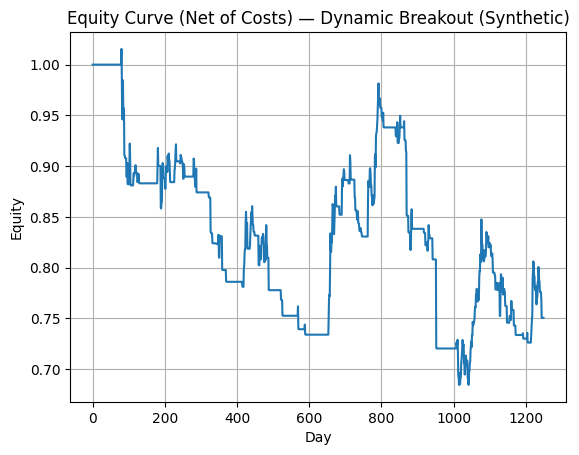

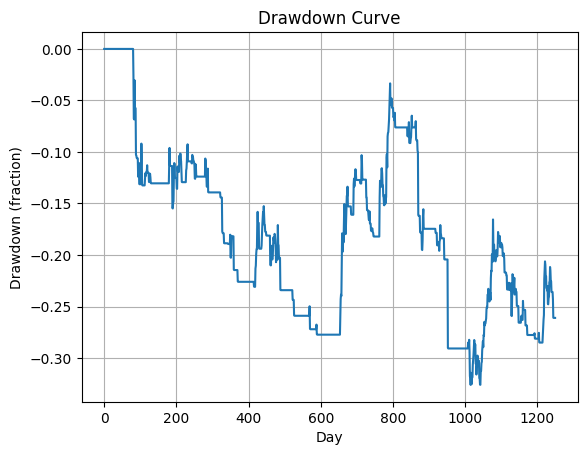

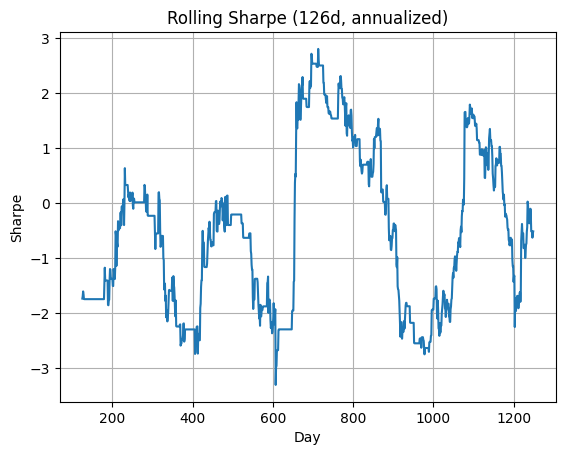

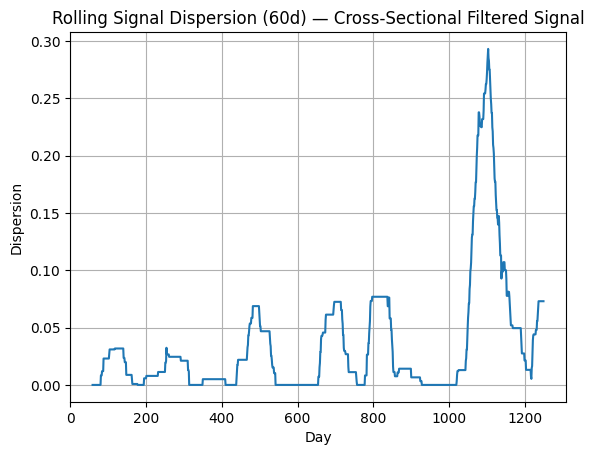

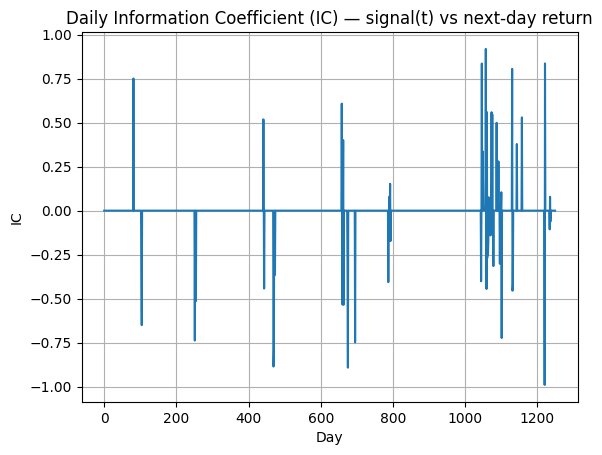

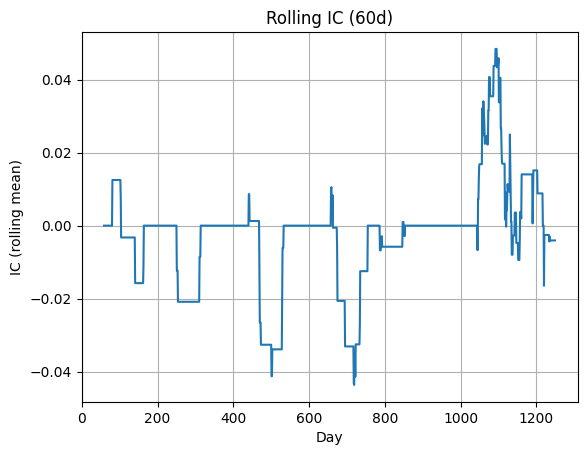

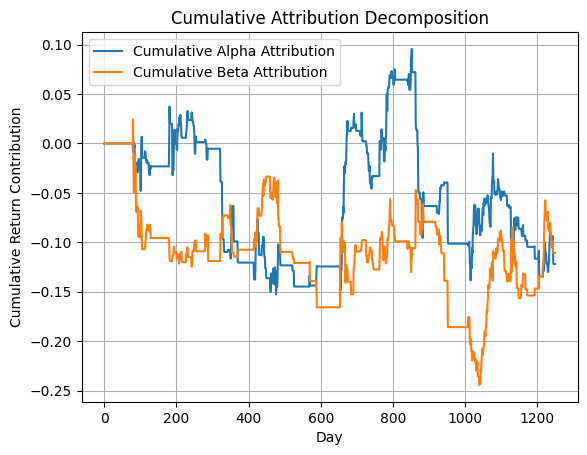

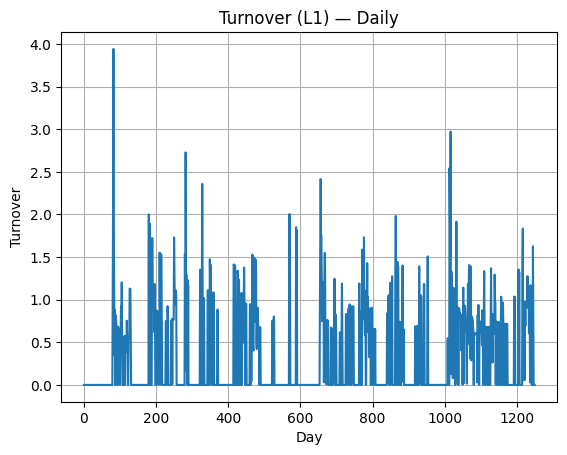

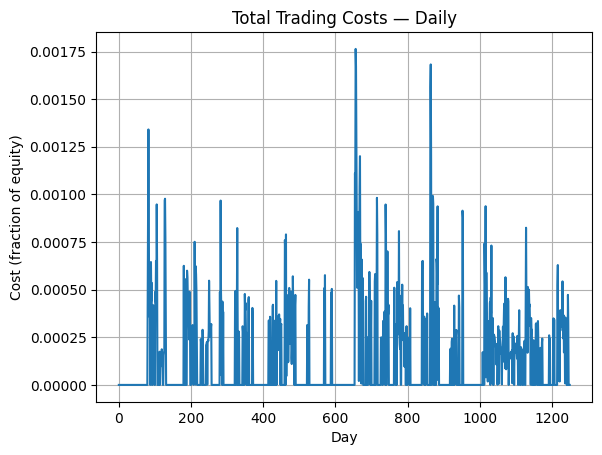

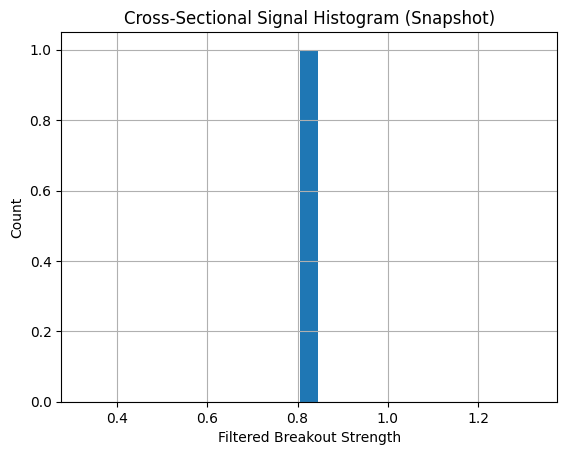

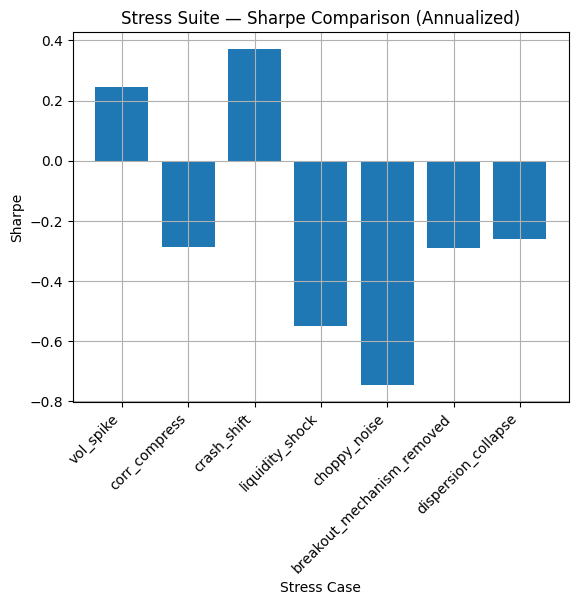

In [8]:
# CELL 9 — Visualization Dashboard (no narrative text; publication-quality matplotlib only)

# Unpack diagnostics series
eq = diagnostics["series"]["equity"]
dd = diagnostics["series"]["drawdown"]
rsh = diagnostics["series"]["rolling_sharpe"]
sd = diagnostics["series"]["signal_dispersion_roll"]
ic_s = diagnostics["series"]["ic_series"]
ic_r = diagnostics["series"]["ic_rolling"]
to = diagnostics["series"]["turnover"]
cs = diagnostics["series"]["costs"]
ca = diagnostics["series"]["cum_alpha_attrib"]
cb = diagnostics["series"]["cum_beta_attrib"]

t = list(range(len(eq)))

plt.figure()
plt.plot(t, eq)
plt.title("Equity Curve (Net of Costs) — Dynamic Breakout (Synthetic)")
plt.xlabel("Day")
plt.ylabel("Equity")
plt.grid(True)

plt.figure()
plt.plot(t, dd)
plt.title("Drawdown Curve")
plt.xlabel("Day")
plt.ylabel("Drawdown (fraction)")
plt.grid(True)

plt.figure()
plt.plot(t, rsh)
plt.title("Rolling Sharpe (126d, annualized)")
plt.xlabel("Day")
plt.ylabel("Sharpe")
plt.grid(True)

plt.figure()
plt.plot(t, sd)
plt.title("Rolling Signal Dispersion (60d) — Cross-Sectional Filtered Signal")
plt.xlabel("Day")
plt.ylabel("Dispersion")
plt.grid(True)

plt.figure()
plt.plot(t, ic_s)
plt.title("Daily Information Coefficient (IC) — signal(t) vs next-day return")
plt.xlabel("Day")
plt.ylabel("IC")
plt.grid(True)

plt.figure()
plt.plot(t, ic_r)
plt.title("Rolling IC (60d)")
plt.xlabel("Day")
plt.ylabel("IC (rolling mean)")
plt.grid(True)

plt.figure()
plt.plot(t, ca, label="Cumulative Alpha Attribution")
plt.plot(t, cb, label="Cumulative Beta Attribution")
plt.title("Cumulative Attribution Decomposition")
plt.xlabel("Day")
plt.ylabel("Cumulative Return Contribution")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, to)
plt.title("Turnover (L1) — Daily")
plt.xlabel("Day")
plt.ylabel("Turnover")
plt.grid(True)

plt.figure()
plt.plot(t, cs)
plt.title("Total Trading Costs — Daily")
plt.xlabel("Day")
plt.ylabel("Cost (fraction of equity)")
plt.grid(True)

# Signal histogram snapshot (use stored sample if available)
plt.figure()
if sig_hist_sample:
    plt.hist(sig_hist_sample, bins=25)
plt.title("Cross-Sectional Signal Histogram (Snapshot)")
plt.xlabel("Filtered Breakout Strength")
plt.ylabel("Count")
plt.grid(True)

# Stress Sharpe comparison
plt.figure()
stress_labels = [r["case"] for r in stress_results]
stress_vals = [r["sharpe"] for r in stress_results]
plt.bar(list(range(len(stress_vals))), stress_vals)
plt.title("Stress Suite — Sharpe Comparison (Annualized)")
plt.xlabel("Stress Case")
plt.ylabel("Sharpe")
plt.xticks(list(range(len(stress_labels))), stress_labels, rotation=45, ha="right")
plt.grid(True)

plt.show()


##10.AUDIT BUNDLE

###10.1.OVERVIEW

**Cell 10 — Maximum Audit Bundle (Sensitivity, Monte Carlo, Hash Integrity, and Regulator-Facing Packaging)**

This cell is the audit and robustness culmination. Its purpose is to generate parameter sensitivity results, construct a Monte Carlo robustness envelope, create an artifact hash registry, write an audit index, and bundle everything into a tamper-evident zip. In institutional research, these steps convert a notebook from a one-off analysis into a reviewable artifact that can be replicated and challenged.

The parameter sensitivity grid is framed as an experimental probe, not an optimization sweep. By varying the breakout lookback window, top-K selection breadth, and target volatility, the notebook maps how the strategy’s behavior changes across structural design choices. For breakouts, these parameters are meaningful. Lookback controls the boundary’s inertia and thus signal frequency. Top-K controls concentration and selection stability. Target volatility controls the aggressiveness of exposure and, indirectly, turnover costs. The grid output allows a reviewer to see whether performance and drawdown behavior are stable across plausible choices or whether results depend on a narrow parameter region.

The Monte Carlo envelope then addresses path dependence and residual variability. Rather than claiming probabilistic truth, it perturbs realized returns with noise calibrated to the observed return dispersion, generating a distribution of terminal equity outcomes. Quantiles provide a robustness summary: if the distribution is wide, the strategy is path-sensitive; if left-tail outcomes are severe, fragility is implied even if the median is benign. For a breakout strategy, this is especially relevant because performance often depends on a subset of persistent runs, and small perturbations can change whether those runs are captured or whether they are interrupted by execution and drawdown controls.

The audit layer is deliberately strict. Every artifact is hashed with SHA-256, a master bundle hash is computed, and an audit index records counts and identifiers. This supports tamper-evidence: if any file changes, hashes change. The reproducibility report references determinism checks that compare full equity series hashes across reruns. This is closer to litigation-grade posture than to casual research practice.

The cell also writes a review checklist that is explicitly incomplete until humans sign off. This enforces the governance boundary: notebooks generate evidence and structure, but they do not grant deployment authority. Finally, the lab bundle zip ensures portability. A reviewer can take the bundle, verify hashes, inspect artifacts, and reproduce results in a controlled environment.

The learning objective is that robustness and governance are part of the strategy’s mechanism story. A breakout policy is not only a signal; it is a system that must survive parameter changes, residual variability, and audit scrutiny. This cell exists to make that professional standard concrete.


###10.2.CODE AND IMPLEMENTATION

In [9]:
# CELL 10 — Maximum Audit Bundle (Sensitivity Grid, Monte Carlo Envelope, Hash Registry, Audit Index, ZIP)

# -----------------------------
# Parameter Sensitivity Grid
# -----------------------------
def run_one_config_variant(lookback_L, top_k, target_vol):
    # Create a shallow config copy for variant
    cfg = json.loads(stable_json_dumps(CONFIG))
    cfg["lookback_L"] = int(lookback_L)
    cfg["top_k"] = int(top_k)
    cfg["target_vol_annual"] = float(target_vol)

    m = generate_synthetic_market(cfg, seed_override=cfg["seed"] + 1_111)
    # signals
    sigf = {}
    for nm in m["names"]:
        px = m["prices"][nm]
        r = m["rets"][nm]
        ch = rolling_max(px, cfg["lookback_L"])
        rv = rolling_std(r, cfg["vol_lookback"])
        sf = [0.0] * cfg["n_days"]
        for t in range(cfg["n_days"]):
            if ch[t] is None or rv[t] is None or rv[t] <= 0:
                continue
            prev_high = max(px[t - cfg["lookback_L"]:t]) if t >= cfg["lookback_L"] else ch[t]
            dist = px[t] - prev_high
            s = safe_div(dist, px[t], 0.0) / rv[t]
            liq_ok = m["liquidity"][nm][t] >= cfg["cost"]["liquidity_floor"]
            rname = m["regimes"][t]
            regime_ok = (s > 0.80) if (rname == "Crash") else (s > 0.0)
            vol_ok = (rv[t] <= 0.030) or (s > 0.45)
            sf[t] = s if (liq_ok and regime_ok and vol_ok) else 0.0
        sigf[nm] = sf

    bt_v = backtest_dynamic_breakout(cfg, m, sigf)
    warm = cfg["warmup_days"]
    sh = annualize_sharpe(bt_v["port_ret"][warm:], rf_annual=cfg["rf_annual"])
    eq = bt_v["equity"]
    mdd, _ = max_drawdown(eq)
    return {"lookback_L": lookback_L, "top_k": top_k, "target_vol_annual": target_vol,
            "final_equity": eq[-1], "sharpe": sh, "max_drawdown": mdd}

grid = []
for L in CONFIG["sensitivity_grid"]["lookback_L"]:
    for k in CONFIG["sensitivity_grid"]["top_k"]:
        for tv in CONFIG["sensitivity_grid"]["target_vol_annual"]:
            grid.append(run_one_config_variant(L, k, tv))

write_json(os.path.join(DELIV_DIR, "parameter_sensitivity.json"), governance_envelope(
    outputs_obj={"grid": grid},
    assumptions={"grid": "Small structured grid; not exhaustive optimization."},
    open_items=["If used beyond research, require pre-registered hypotheses to avoid p-hacking."]
))

# -----------------------------
# Monte Carlo Robustness Envelope (>=200 sims)
# Perturb daily returns with residual noise (deterministic seeds)
# -----------------------------
def monte_carlo_envelope(base_returns, n_sims, sigma_mult, seed_base):
    rng_master = random.Random(seed_base)
    # estimate residual scale
    mu = statistics.mean(base_returns) if base_returns else 0.0
    sd = statistics.pstdev(base_returns) if len(base_returns) > 1 else 0.0
    sd = max(sd, 1e-8)

    terminals = []
    paths_sample = []
    for i in range(n_sims):
        seed_i = rng_master.randint(0, 10**9)  # deterministic because rng_master is deterministic
        rng = random.Random(seed_i)
        eq = 1.0
        eq_path = []
        for r in base_returns:
            noise = rng.gauss(0.0, sd * sigma_mult)
            rp = r + noise
            eq *= (1.0 + rp)
            if i < 8:  # store a few sample paths
                eq_path.append(eq)
        terminals.append(eq)
        if i < 8:
            paths_sample.append(eq_path)

    terminals_sorted = sorted(terminals)
    def pct(p):
        idx = int(clamp(p, 0.0, 1.0) * (len(terminals_sorted) - 1))
        return terminals_sorted[idx]

    envelope = {
        "n_sims": n_sims,
        "terminal_stats": {
            "p05": pct(0.05),
            "p25": pct(0.25),
            "p50": pct(0.50),
            "p75": pct(0.75),
            "p95": pct(0.95),
            "mean": statistics.mean(terminals),
            "stdev": statistics.pstdev(terminals) if len(terminals) > 1 else 0.0
        },
        "sample_paths": paths_sample
    }
    return envelope

mc = monte_carlo_envelope(
    base_returns=bt["port_ret"][CONFIG["warmup_days"]:-1],
    n_sims=CONFIG["monte_carlo"]["n_sims"],
    sigma_mult=CONFIG["monte_carlo"]["shock_sigma_mult"],
    seed_base=CONFIG["seed"] + CONFIG["monte_carlo"]["seed_offset"]
)

write_json(os.path.join(DELIV_DIR, "monte_carlo_envelope.json"), governance_envelope(
    outputs_obj=mc,
    assumptions={"mc_method": "Return perturbation around realized synthetic returns; not a full structural resimulation."},
    open_items=["Consider block bootstrap or regime-conditional residuals for more realism."]
))

# -----------------------------
# Review checklist (committee-ready)
# -----------------------------
review_checklist = {
    "pre_registered_hypothesis": "Not provided",
    "data_policy_confirmed_synthetic": True,
    "determinism_check": "See deliverables/governance_maturity.json",
    "stress_suite_reviewed": "Pending",
    "execution_model_reviewed": "Pending calibration discussion",
    "fragility_and_tiering_reviewed": "Pending",
    "approval_signatures": []
}
write_json(os.path.join(DELIV_DIR, "review_checklist.json"), governance_envelope(
    outputs_obj=review_checklist,
    assumptions={},
    open_items=["Requires human sign-off before any external communication."]
))

# -----------------------------
# Artifact hash registry + audit index + reproducibility report
# -----------------------------
artifact_paths = [
    RUN_MANIFEST_PATH, PROMPTS_LOG_PATH, RISK_LOG_PATH,
    os.path.join(DELIV_DIR, "metrics_summary.json"),
    os.path.join(DELIV_DIR, "diagnostics.json"),
    os.path.join(DELIV_DIR, "equity_curve.json"),
    os.path.join(DELIV_DIR, "positions.json"),
    os.path.join(DELIV_DIR, "stress_test_results.json"),
    os.path.join(DELIV_DIR, "parameter_sensitivity.json"),
    os.path.join(DELIV_DIR, "monte_carlo_envelope.json"),
    os.path.join(DELIV_DIR, "fragility_analysis.json"),
    os.path.join(DELIV_DIR, "model_risk_score.json"),
    os.path.join(DELIV_DIR, "governance_maturity.json"),
    os.path.join(DELIV_DIR, "deployment_status.json"),
    os.path.join(DELIV_DIR, "signal_matrix.json"),
    os.path.join(DELIV_DIR, "execution_audit.json"),
    os.path.join(DELIV_DIR, "review_checklist.json")
]

hash_registry = {"artifacts": [], "master_bundle_hash_sha256": None}
for p in artifact_paths:
    if os.path.exists(p):
        hash_registry["artifacts"].append({"path": os.path.relpath(p, ROOT_DIR), "sha256": file_sha256(p)})

master_hash = sha256_hex(stable_json_dumps(hash_registry["artifacts"]))
hash_registry["master_bundle_hash_sha256"] = master_hash

write_json(os.path.join(DELIV_DIR, "artifact_hash_registry.json"), governance_envelope(
    outputs_obj=hash_registry,
    assumptions={"hash": "SHA-256 over file bytes; master hash over sorted registry JSON."},
    open_items=[]
))

repro_report = {
    "run_id": run_id,
    "timestamp_utc": utc_now_iso(),
    "config_hash_sha256": config_hash,
    "reproducibility_check": json.loads(open(os.path.join(DELIV_DIR, "governance_maturity.json"), "r", encoding="utf-8").read())["outputs"]["reproducibility_check"],
    "notes": "Reproducibility is defined as identical equity series under identical CONFIG and seed."
}
write_json(os.path.join(DELIV_DIR, "reproducibility_report.json"), governance_envelope(
    outputs_obj=repro_report,
    assumptions={},
    open_items=["If any dependency changes, rerun and re-certify."]
))

audit_index = {
    "run_id": run_id,
    "timestamp_utc": utc_now_iso(),
    "strategy": {"id": CONFIG["strategy_id"], "name": CONFIG["strategy_name"]},
    "bundle": {"master_bundle_hash_sha256": master_hash},
    "deliverables_dir": os.path.relpath(DELIV_DIR, ROOT_DIR),
    "artifact_count": len(hash_registry["artifacts"])
}
write_json(os.path.join(DELIV_DIR, "audit_index.json"), governance_envelope(
    outputs_obj=audit_index,
    assumptions={},
    open_items=[]
))

# -----------------------------
# Build lab_bundle.zip (all artifacts + root files)
# -----------------------------
bundle_path = os.path.join(ROOT_DIR, "lab_bundle.zip")
with zipfile.ZipFile(bundle_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    # root files
    for p in [RUN_MANIFEST_PATH, PROMPTS_LOG_PATH, RISK_LOG_PATH]:
        if os.path.exists(p):
            z.write(p, arcname=os.path.relpath(p, ROOT_DIR))
    # deliverables
    for root, _, files in os.walk(DELIV_DIR):
        for fn in files:
            fp = os.path.join(root, fn)
            z.write(fp, arcname=os.path.relpath(fp, ROOT_DIR))

print("Bundle created:", bundle_path)
print("Master bundle hash (sha256):", master_hash)


Bundle created: /content/lab_bundle.zip
Master bundle hash (sha256): 48bc6c09090dc47f3968340956ea05136548726c126ea6790767837361493ddc


##11.CONCLUSION

**Conclusion — Dynamic Breakout Laboratory (Strategy 9)**

The Dynamic Breakout laboratory is intentionally structured to teach a particular kind of professional intuition: the ability to explain outcomes in terms of **mechanisms and constraints** rather than in terms of stories about “alpha.” The notebook’s central contribution is not a performance number; it is the explicit construction of a closed loop in which a breakout policy interacts with a regime-conditioned market structure, pays an execution price that depends on liquidity and turnover, and leaves behind a set of auditable artifacts that allow an independent reviewer to replicate, stress, and critique the result.

The first lesson is that breakout signals are not universal objects. They are conditional. In the synthetic environment, the same signal definition—distance above a rolling channel high normalized by volatility—can represent very different economic meanings depending on regime. In calm trending states, the signal is an expression of path persistence, where the environment’s trend component and drift interact to produce continuation. In choppy states, the same boundary crossing may represent transient noise, quickly reversed by microstructure-like dynamics. In crash states, the signal can be deceptive: correlation rises, liquidity drops, and what looks like “strength” can be a temporary rebound inside a broader liquidation regime. The notebook encodes that professional caution through regime gates and volatility feasibility filters, emphasizing that a policy must decide not only what to buy, but when not to participate.

The second lesson is that cross-sectional selection is itself a source of fragility. The top-K rule creates a discrete selection boundary. Small changes in the signal distribution can lead to large changes in holdings. That instability becomes visible in the turnover series and in the execution costs, particularly when the policy rotates between names during regime transitions. This is not an implementation detail; it is the core of breakout capacity risk. A breakout policy is often most active when the market is reorganizing leadership, and that is exactly when liquidity conditions can change. The notebook’s convex impact model makes this visible: the marginal cost of rebalancing increases nonlinearly with trade size and inversely with liquidity. The policy can therefore encounter a capacity cliff where the “best” theoretical action is prohibitively expensive. This is why execution dominates theory: it is not enough to have a signal that points in the right direction. The policy must be able to move.

The third lesson concerns surfaces. Many practitioners speak about regimes and risk in qualitative terms. This laboratory turns those ideas into interpretable surfaces: a signal dispersion surface that indicates whether cross-sectional differentiation exists, a turnover surface that indicates how rapidly the policy must change inventory, a cost surface that quantifies how expensive that change is, and a drawdown surface that emerges from the coupling of exposure and execution. These surfaces allow the researcher to reason structurally. If stress tests show a large Sharpe degradation under correlation compression, that is not merely “bad luck”; it indicates that dispersion collapsed and the selection mechanism lost differentiation. If drawdowns amplify under liquidity shock, that indicates the policy could not rotate away from deteriorating states without paying an execution premium that overwhelmed expected continuation. The surfaces provide a language for causality.

Fragility modes become clearer once the policy is viewed this way. A dynamic breakout policy is fragile when it depends on a narrow set of structural assumptions: sufficient dispersion across assets, persistence at the chosen horizon, and tradability under liquidity constraints. The notebook’s strategy-specific stresses are designed to attack those assumptions directly. Removing the breakout mechanism by setting trend persistence to zero tests whether the policy is truly exploiting continuation or merely harvesting drift and noise. Collapsing dispersion tests whether the policy’s cross-sectional selection is essential or whether it is effectively a market beta proxy. Generic stresses then probe the broader fragility landscape: volatility spikes and crash shifts test exposure feasibility and tail behavior; correlation compression tests the collapse of cross-sectional differentiation; liquidity shocks test capacity cliffs; choppy noise tests whether the breakout rule becomes an overtrading machine. The results are not “pass/fail.” They are maps of where the policy’s assumptions bind.

The notebook’s governance engine then formalizes fragility as a composite score that combines stress degradation, drawdown amplification, and turnover penalties. The point is not to claim regulatory completeness; the point is to show how an institution can convert diagnostics into an auditable risk tiering decision. Model risk tiering is a practical necessity. A strategy whose behavior changes discontinuously under small perturbations should not be treated as a low-risk research artifact, even if its baseline performance looks attractive in one run. Conversely, a strategy that degrades gracefully under multiple perturbations may be eligible for more controlled experimentation. The deployment classification output—research only, paper trading eligible, limited capital pilot—is framed as governance guidance, not authorization. The discipline is to treat synthetic evidence as hypothesis support, not as validation.

A key professional insight from this laboratory is the need to iterate experimentally rather than optimize. The notebook includes parameter sensitivity grids and Monte Carlo robustness envelopes not to find the “best” configuration, but to reveal how the policy behaves when its design choices change. In a breakout strategy, the lookback window defines the boundary’s responsiveness; shorter windows increase signal frequency and often turnover, while longer windows reduce churn but can miss transitions. The top-K parameter controls concentration and selection stability. The target volatility influences how aggressively the policy expresses the signal and how costs scale with turnover. These are not tuning knobs; they are structural commitments. The correct iteration posture is to treat each parameter shift as a causal probe: does the policy become more fragile because turnover rises into the convex part of the cost surface, or because the signal becomes dominated by noise? The sensitivity grid offers a controlled way to ask those questions.

The Monte Carlo envelope provides a complementary lesson: even within a fixed environment, path dependence matters. By perturbing returns, the notebook generates a distribution of terminal outcomes that can be summarized by quantiles. This is not a claim about real-world probability; it is a demonstration that single-run outcomes can be misleading even in deterministic synthetic systems once one considers plausible residual variability. A practitioner should internalize the idea that robustness is not a slogan; it is an empirical object that must be measured, logged, and reviewed.

Finally, the laboratory reinforces why this is a learning environment and not a trading system. The regime process is designed; it is not inferred. Liquidity and spread proxies are stylized; they are not venue-calibrated. The cost model captures convexity and liquidity dependence, but it is not a replacement for execution research. The signal is intentionally simple and transparent to facilitate causal reasoning. The notebook’s value is therefore pedagogical and methodological: it teaches a disciplined approach to building, testing, and governing a mechanism-first strategy archetype.

In closing, the Dynamic Breakout notebook should change how one thinks about breakouts. A breakout strategy is not a belief in trends; it is a policy navigating a set of surfaces imposed by market structure. It succeeds when persistence exists where execution is feasible, and it fails when dispersion collapses, regimes invert continuation, or liquidity stress pushes the policy into a capacity cliff. The laboratory makes those statements testable. That is the professional outcome: not a promise of returns, but a clearer mental model of mechanisms, constraints, and failure modes.

